# Binary Similarity Notebooks

Nomenclature: BinSim_Datasets_pre-made normalization

In this case BinSim_YD_norm.ipynb

There isn't an 'Analysis' in the name btween BinSim and YD to separate from the notebooks used for the dissertation.

### Warning

See the notebook BinSim_Analysis_YD_notnorm.ipynb for the notebook with the data and figures on the dissertation.

## Organization of the Notebook

- Imports and Presentation of the Yeast Dataset analysed in this notebook
- Reading the Positive Yeast dataset (dataset 1 - Yeast Dataset - YD)
- Filtering dataset to only include m/z peaks with formulas assigned (in MetaboScape) and make formulas the features (dataset 2 - Yeast Formula Dataset - YFD)
- Performing the different pre-treatments (including BinSim) on the datasets
- Preliminary analysis on the YD
- Agglomerative Hierarchical Clustering and K-means Clustering
- Random Forest - predictive accuracy and important features
- PLS-DA - predictive accuracy and important features
- Permutation Tests

### Needed Imports

In [1]:
import numpy as np
import pandas as pd
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import seaborn as sns
import itertools

# Metabolinks package
import metabolinks as mtl
import metabolinks.transformations as transf
from metabolinks.similarity import mz_similarity

# Python files in the repository
import scaling as sca
import multianalysis as ma

C:\Users\francisco\Anaconda3\lib\site-packages\xarray\core\merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
%matplotlib inline

# Similarity analysis with BinSim and different combinations of traditional pre-treatments - Yeast (Norm)

The Yeast dataset was acquired by J. Luz. The Yeast dataset consists of 15 samples of FT-ICR-MS metabolomics data obtained in positive ionization mode - 3 biological replicates of 5 different strains of _Saccharomyces cerevisiae_: the reference strain BY4741 (represented as BY) and 4 single-gene deletion mutants of this strain – ΔGLO1, ΔGLO2, ΔGRE3 and ΔENO1 represented, respectively, as dGLO1, dGLO2, dGRE3 and dENO1. These deleted genes are directly or indirectly related to methylglyoxal metabolism.

Peak Alignment and Peak Filtering was performed with MetaboScape 4.0 software (see dissertation for details in sample preparation, pre-processing, formula assignment). In short, the peak filtering made was made by keeping all features that appeared in at least 2 samples of the full dataset.

Yeast Dataset was obtained with Electrospray Ionization in Positive Mode, Human leucine enkephalin (Sigma Aldrich) is the reference feature (internal standard) used ([M+H]+ = 556.276575 Da or [M-H]- = 554.262022 Da) and pre-processed by MetaboScape 4.0 (Bruker Daltonics) - see dissertation for details in pre-processing and formula assignment.

To better understand the functions used outside of normal Python packages, see scaling.py and multianalysis.py where they are better described.

### 2 Yeast Datasets where features are present in at least two samples:

#### 1st Dataset: YD (Yeast Dataset) - Yeast Dataset read using m/z peaks as features

#### 2nd Dataset: YFD (Yeast Formula Dataset) - Yeast Dataset read using formulas as features

#### Read aligned file from .csv files - Building the datasets

File:

'5yeasts_norm.csv' - Dataset with pre-normalization by the reference feature Leucine Enkephalin made by the MetaboScape 4.0 (Bruker Daltonics) sfotware (equal to the normalization function in scaling.py but having all leucine peaks at a certain intensity instead of 1 as it happens in the scaling.py module).

##### The alignment should've been identical, however the m/z delta (MetaboScape parameter) used was 1.0 (instead of 1.1 like in the other dataset). So it is slightly different than the other Yeast Dataset.

#### Note: This dataset was pre-normalized by MetaboScape before missing value imputation. As such, performing normalization on this dataset is not needed. Thus, this pre-treatment stage will be skipped. To substitute the NP pre-treatment used in other notebooks, this wil linclude using only missing value imputation (Imp) as one of the 3 combinations of traditional pre-treatments (normalization and missing value imputation).

In [3]:
def reading_MetScape_file(filename,
                          col_renamer=None,
                          add_labels=None,
                          remove_ref_feat=None,
                          prefix_to_drop=None):
    
    """Read in a MetaboScape bucket table from a CSV file."""
    
    data = pd.read_csv(filename).set_index('Bucket label')
    
    # optionally rename sample_names
    if col_renamer is not None:
        data = data.rename(columns=renamer)
    
    # optionally remove columns with a given prefix. Eg. 'ENO'
    if prefix_to_drop is not None:
        cols2drop = [c for c in data.columns if c.startswith(prefix_to_drop)]
        data = data.drop(columns=cols2drop)
    
    # optionally remove a reference feature (if already normalized)
    if remove_ref_feat is not None:
        #print(f'Feature {remove_ref_feat}\n{data.loc[remove_ref_feat, :]}\n----------')
        data = data.drop(index=[remove_ref_feat])
    
    # split in peak metadata and intensities
    peak_cols = ['m/z', 'Name', 'Formula']
    intensity_cols = [c for c in list(data.columns) if c not in peak_cols]
    peaks = data[peak_cols]
    intensities = data[intensity_cols]

    # replace zeros for NaN's
    intensities = intensities.replace(0, np.nan).dropna(how='all')
    
    # force peaks to have the same features as the (trimmed) intensities
    peaks = peaks.reindex(intensities.index)

    # optionally, add labels to intensities
    if add_labels is not None:
        intensities = mtl.add_labels(intensities, labels=add_labels)
    
    return {'filename': filename,
            'peaks':peaks,
            'intensities': intensities}

In [4]:
def renamer(colname):
    # Util to optionally remove all those 00000 from sample names
    return ''.join(colname.split('00000'))

# Reference Feature in the dataset
leu_enk_name = '555.2692975341 Da'

# Labels of the 5 biological groups (5 yeast strains) - only added after
labels = 'BY4741 dGRE3 dENO1 dGLO1 dGLO2'.split() # if ENO is removed, change this

In [5]:
# Read in the file and keep results in dicts 

prefix_to_drop = None # change to 'ENO' to remove ENO strain

# MScape normalized dataset
Mscape_normalized = reading_MetScape_file('5yeasts_norm.csv', 
                                       remove_ref_feat=leu_enk_name,
                                       add_labels=None,
                                       col_renamer=renamer,
                                       prefix_to_drop=prefix_to_drop)

Mscape_normalized

{'filename': '5yeasts_norm.csv',
 'peaks':                            m/z                   Name          Formula
 Bucket label                                                          
 307.0838178877 Da    308.09110            Glutathione      C10H17N3O6S
 624.0873082632 Da    625.09457                    NaN   C14H28N10O10S4
 493.3168156897 Da    494.32410        PC_16:1_9Z_0:0_       C24H48NO7P
 257.1028750516 Da    258.11016  Glycerophosphocholine        C8H20NO6P
 780.1092067055 Da    781.11647                    NaN   C21H33N8O18PS2
 ...                        ...                    ...              ...
 2029.1188620710 Da  2030.12614                    NaN              NaN
 532.8123880500 Da    533.81966                    NaN      C9H4N5O8PS6
 1069.9969559833 Da  1071.00423                    NaN   C37H18N16O16S4
 1343.9006014319 Da  1344.90788                    NaN   C57H32N6O12S11
 1941.3559575318 Da  1942.36323                    NaN  C39H66N47O39P3S
 
 [21327 rows x 3 col

## YD - Yeast Dataset

### Removing rare features (features that only appear in 1 sample)

In [6]:
# Removing features - Lots of features that appear in only 1 sample - non-informative.
# Function keep_atleast accepts argument min_samples
# (integer: number of samples, [0,1[: fraction to keep)

Yeast_dfs ={}
Yeast_dfs['filename'] = Mscape_normalized['filename']
Yeast_dfs['peaks'] = Mscape_normalized['peaks']
Yeast_dfs['intensities'] = transf.keep_atleast(Mscape_normalized['intensities'], min_samples=2)

In [7]:
Yeast_dfs['intensities']

,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
Bucket label,,,,,,,,,,,,,,,
307.0838178877 Da,1.482951e+09,1.520914e+09,1.515563e+09,1.231184e+09,1.205245e+09,1.227117e+09,7.151679e+08,7.148845e+08,7.031374e+08,5.903519e+08,5.864704e+08,5.959080e+08,2.877227e+08,2.914869e+08,2.920921e+08
624.0873082632 Da,4.933358e+08,4.858229e+08,4.977819e+08,5.939113e+08,5.818669e+08,5.844022e+08,3.827252e+08,3.834892e+08,3.807282e+08,2.709398e+08,2.645076e+08,2.677631e+08,1.314990e+08,1.330865e+08,1.320918e+08
493.3168156897 Da,4.026932e+08,4.174214e+08,4.232130e+08,4.742500e+08,4.770647e+08,4.894069e+08,8.762351e+07,8.903744e+07,8.863885e+07,8.300221e+07,8.356744e+07,8.238210e+07,5.642838e+07,5.809368e+07,5.933968e+07
257.1028750516 Da,2.056732e+08,2.052868e+08,2.117945e+08,2.113430e+08,1.993518e+08,2.069864e+08,2.030151e+08,1.999564e+08,1.930296e+08,1.212009e+08,1.165595e+08,1.169341e+08,5.954985e+07,6.113070e+07,6.227151e+07
780.1092067055 Da,1.284203e+08,1.246610e+08,1.314768e+08,1.509135e+08,1.538552e+08,1.479185e+08,9.888932e+07,1.000064e+08,9.630288e+07,6.675784e+07,6.744662e+07,7.063488e+07,3.361880e+07,3.281881e+07,3.356464e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892.5313342202 Da,NaN,NaN,NaN,2.491379e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.553795e+05,NaN
847.0028787316 Da,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.562285e+06,NaN,NaN,NaN,1.101325e+06,NaN,NaN,NaN
535.6351204857 Da,NaN,NaN,NaN,NaN,NaN,NaN,1.544839e+06,NaN,NaN,NaN,NaN,NaN,5.424146e+05,NaN,NaN


## YFD - Yeast Formula Dataset

### Unite all features that share the same formula, removing rare features (features that only appear in 1 sample) and use Formulas as the new index of the dataset

In [8]:
def feature_filter(Spectra):
    """Unite all features that share the same formula into one by simple addition (of intensities).
       
       Spectra: Pandas DataFrame; metabolomics dataset.
       
       Returns: Pandas DataFrame with filtered dataset.
    """
    df = Spectra
    # Variables to store results
    rp = pd.DataFrame(columns = df.columns)
    rep = []
    # Series with number of times each formula appears in the dataset
    form_count = df['Formula'].value_counts()
    a = 0
    
    for i in df['Formula']:
        if pd.isnull(i) == True: # If no formula is assigned to the feature, the feature stays in the new dataset
            rp = rp.append(df.iloc[a,:])

        else:
            if form_count[i] > 1: # If the formula appears more than one time in the dataset
                if i not in rep: # And If it didn't already appear before
                    
                    # Bucket label, name and formula info are the ones from the greater intensity m/z peak (of peaks with the
                    # same formula)
                    peaks = df.loc[df['Formula'] == i,:].iloc[:,4:].sum(axis = 1)
                    peaks_idx = peaks.idxmax()
                    info = df.loc[peaks_idx].iloc[:4]
                    newrow = df.loc[df['Formula'] == i,:].iloc[:,4:].sum(axis = 0) # Addition of all m/z peaks intensity
                    newrow_c = pd.concat([info, newrow], axis = 0)
                    
                    # m/z peak stays is from the greater intensity m/z peak (of peaks with the same formula)
                    newrow_c = newrow_c.rename(df.loc[peaks_idx].name)
                    
                    # Append peak with intensity added from all peaks sharing the same formula
                    rp = rp.append(newrow_c)

                    rep.append(i) # Append repeating formulas so this process isn't repeated again for the other m/z peaks

            else: 
                # Append peaks with formulas that aren't repeated in the dataset
                rp = rp.append(df.iloc[a,:]) 
    
        a = a + 1
    
    # return filtered DataFrame
    return rp

In [9]:
# form (Formula)
Yeast_form_dfs ={}
Yeast_form_dfs['filename'] = Mscape_normalized['filename']
Yeast_form_dfs['peaks'] = Mscape_normalized['peaks']

In [10]:
# Join Metadata with intensities temporarily
Yeast_form_df_temp = pd.concat([Mscape_normalized['peaks'],Mscape_normalized['intensities']], axis=1)
Yeast_form_df_temp = Yeast_form_df_temp.dropna(subset = ['Formula']) # Drop peaks without formulas

# Unite all features that share the same formula into one by simple addition (of intensities)
Yeast_form_df_temp = feature_filter(Yeast_form_df_temp)

# Keep only features that appear in at least two samples on the dataset and change the index of Yeast_form_dfs['intensities']
# to formulas
Yeast_form_df_temp = Yeast_form_df_temp.loc[
    (transf.keep_atleast(Yeast_form_df_temp.iloc[:,3:].replace({0:np.nan}), min_samples=2)).index].replace({0:np.nan})
Yeast_form_dfs['intensities'] = Yeast_form_df_temp.iloc[:,3:]
Yeast_form_dfs['intensities'].index = Yeast_form_df_temp['Formula']
Yeast_form_dfs['intensities']

,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
Formula,,,,,,,,,,,,,,,
C10H17N3O6S,1.482951e+09,1.520914e+09,1.515563e+09,1.231184e+09,1.205245e+09,1.227117e+09,7.151679e+08,7.148845e+08,7.031374e+08,5.903519e+08,5.864704e+08,5.959080e+08,2.877227e+08,2.914869e+08,2.920921e+08
C14H28N10O10S4,4.933358e+08,4.858229e+08,4.977819e+08,5.939113e+08,5.818669e+08,5.844022e+08,3.827252e+08,3.834892e+08,3.807282e+08,2.709398e+08,2.645076e+08,2.677631e+08,1.314990e+08,1.330865e+08,1.320918e+08
C24H48NO7P,4.026932e+08,4.355728e+08,4.394227e+08,5.019047e+08,5.090951e+08,5.508871e+08,9.021053e+07,9.723223e+07,9.441041e+07,8.667450e+07,9.070231e+07,8.744638e+07,6.056658e+07,6.397757e+07,6.217138e+07
C8H20NO6P,2.056732e+08,2.052868e+08,2.117945e+08,2.113430e+08,1.993518e+08,2.069864e+08,2.030151e+08,1.999564e+08,1.930296e+08,1.212009e+08,1.165595e+08,1.169341e+08,5.954985e+07,6.113070e+07,6.227151e+07
C21H33N8O18PS2,1.284203e+08,1.246610e+08,1.314768e+08,1.509135e+08,1.538552e+08,1.479185e+08,9.888932e+07,1.000064e+08,9.630288e+07,6.675784e+07,6.744662e+07,7.063488e+07,3.361880e+07,3.281881e+07,3.356464e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C43H82O16P2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.779705e+06,NaN,NaN,1.190464e+06,NaN,NaN,NaN,NaN
C26H30O13,NaN,NaN,2.117462e+06,2.789437e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C46H92O13P2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.731160e+06,NaN,1.140097e+06,NaN,NaN,NaN,NaN,NaN


### Global metadata for consistency between tables and plots

In [11]:
# Adding the labels of the groups to each DataFrame
mtl.add_labels(Yeast_dfs['intensities'], labels = labels)
mtl.add_labels(Yeast_form_dfs['intensities'], labels = labels)

label                 BY4741                                     dGRE3  \
                       BY0_1         BY0_2         BY0_3        GRE3_1   
Formula                                                                  
C10H17N3O6S     1.482951e+09  1.520914e+09  1.515563e+09  1.231184e+09   
C14H28N10O10S4  4.933358e+08  4.858229e+08  4.977819e+08  5.939113e+08   
C24H48NO7P      4.026932e+08  4.355728e+08  4.394227e+08  5.019047e+08   
C8H20NO6P       2.056732e+08  2.052868e+08  2.117945e+08  2.113430e+08   
C21H33N8O18PS2  1.284203e+08  1.246610e+08  1.314768e+08  1.509135e+08   
...                      ...           ...           ...           ...   
C43H82O16P2              NaN           NaN           NaN           NaN   
C26H30O13                NaN           NaN  2.117462e+06  2.789437e+06   
C46H92O13P2              NaN           NaN           NaN           NaN   
C52H98O5                 NaN           NaN           NaN           NaN   
C18H26N5O8PS2            NaN           NaN           NaN           NaN   

label                                              dENO1                \
                      GRE3_2        GRE3_3        ENO1_1        ENO1_2   
Formula                                                                  
C10H17N3O6S     1.205245e+09  1.227117e+09  7.151679e+08  7.148845e+08   
C14H28N10O10S4  5.818669e+08  5.844022e+08  3.827252e+08  3.834892e+08   
C24H48NO7P      5.090951e+08  5.508871e+08  9.021053e+07  9.723223e+07   
C8H20NO6P       1.993518e+08  2.069864e+08  2.030151e+08  1.999564e+08   
C21H33N8O18PS2  1.538552e+08  1.479185e+08  9.888932e+07  1.000064e+08   
...                      ...           ...           ...           ...   
C43H82O16P2              NaN           NaN           NaN  1.779705e+06   
C26H30O13                NaN           NaN           NaN           NaN   
C46H92O13P2              NaN           NaN           NaN  1.731160e+06   
C52H98O5        2.575508e+06           NaN           NaN           NaN   
C18H26N5O8PS2            NaN           NaN  1.507294e+06           NaN   

label                                dGLO1                              \
                      ENO1_3       dGLO1_1       dGLO1_2       dGLO1_3   
Formula                                                                  
C10H17N3O6S     7.031374e+08  5.903519e+08  5.864704e+08  5.959080e+08   
C14H28N10O10S4  3.807282e+08  2.709398e+08  2.645076e+08  2.677631e+08   
C24H48NO7P      9.441041e+07  8.667450e+07  9.070231e+07  8.744638e+07   
C8H20NO6P       1.930296e+08  1.212009e+08  1.165595e+08  1.169341e+08   
C21H33N8O18PS2  9.630288e+07  6.675784e+07  6.744662e+07  7.063488e+07   
...                      ...           ...           ...           ...   
C43H82O16P2              NaN           NaN  1.190464e+06           NaN   
C26H30O13                NaN           NaN           NaN           NaN   
C46H92O13P2              NaN  1.140097e+06           NaN           NaN   
C52H98O5                 NaN           NaN           NaN           NaN   
C18H26N5O8PS2            NaN           NaN  1.121649e+06           NaN   

label                  dGLO2                              
                      GLO2_1        GLO2_2        GLO2_3  
Formula                                                   
C10H17N3O6S     2.877227e+08  2.914869e+08  2.920921e+08  
C14H28N10O10S4  1.314990e+08  1.330865e+08  1.320918e+08  
C24H48NO7P      6.056658e+07  6.397757e+07  6.217138e+07  
C8H20NO6P       5.954985e+07  6.113070e+07  6.227151e+07  
C21H33N8O18PS2  3.361880e+07  3.281881e+07  3.356464e+07  
...                      ...           ...           ...  
C43H82O16P2              NaN           NaN           NaN  
C26H30O13                NaN           NaN           NaN  
C46H92O13P2              NaN           NaN           NaN  
C52H98O5                 NaN  5.685699e+05  6.009329e+05  
C18H26N5O8PS2            NaN           NaN           NaN  

[1579 rows x 15 columns]

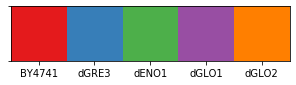

In [12]:
# Useful variables for later on
sample_names = Yeast_dfs['intensities'].cdl.samples
all_labels = Yeast_dfs['intensities'].cdl.labels
unique_labels = Yeast_dfs['intensities'].cdl.unique_labels

# customize these colors
#colours = cm.get_cmap('nipy_spectral', 5)(range(5))
colours = sns.color_palette('Set1', 9)

label_colors = {lbl: c for lbl, c in zip(unique_labels, colours)}

sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(unique_labels)), unique_labels)

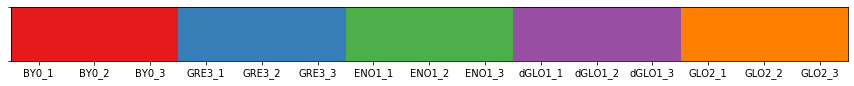

In [13]:
sample_colors = {s: label_colors[lbl] for s, lbl in zip(sample_names, all_labels)}

sns.palplot(sample_colors.values())
new_ticks = plt.xticks(range(len(sample_names)), sample_names)

## Data transformations and pre-treatments

### Each Dataset is transformed to binary or treated by a combination of more established treatments


### Traditional Pre-Treatments

All samples need to have missing value imputation (removing features is optional). In this case, missing features were replaced with half of the minimum intensity of the full dataset.

This can be done with the `NaN_Imputation` function of scaling.py or `fillna_frac_min`(more options available) from metabolinks.

#### 3/4 types of combinations of traditional pre-treatments are made:

##### Imp (Ionly) - Only Missing Value Imputation - Substitute NP

##### P Treatment - Missing Value Imputation and Pareto Scaling.

NP Treatment - Missing Value Imputation, Normalization by reference feature and Pareto Scaling. - Not used, normalization pre-made.

##### NGP Treatment - Missing Value Imputation, Generalized Logarithmic Transformation and Pareto Scaling.

Note: Leucine Enkephalin peak is already removed - reference feature.

### Binary Similarity

##### BinSim - `df_to_bool` function (very simple)

In [14]:
# Represents Binary Similarity pre-treatment
def df_to_bool(df):
    "Transforms data into 'binary' matrices."
    return df.mask(df.notnull(), 1).mask(df.isnull(), 0)

def compute_transf(dataset, norm_ref=None, lamb=None):
    "Computes 3 combinations of pre-treatments and BinSim and returns original and after treatment datasets in a dict."
    
    intensities = dataset['intensities']
    
    # Imputation of Missing Values
    imputed = transf.fillna_frac_min(intensities, fraction=0.5)
    
    # Normalization by a reference feature
    if norm_ref is not None:
        norm = transf.normalize_ref_feature(imputed, norm_ref, remove=True)
    else:
        norm = imputed
        
    # Pareto Scaling and Generalized Logarithmic Transformation
    P = transf.pareto_scale(imputed)
    #NP = transf.pareto_scale(norm)
    NGP = transf.pareto_scale(transf.glog(norm, lamb=lamb))
    
    # Store Results
    dataset['binary'] = df_to_bool(intensities)
    dataset['Ionly'] = imputed
    dataset['P'] = P
    #dataset['NP'] = NP
    dataset['NGP'] = NGP

#### Performing different combinations of pre-treatments and BinSim for the YD and YFD

In [15]:
# No Normalization - no reference feature (already removed from dataset)

# YD
compute_transf(Yeast_dfs, norm_ref=None)

# YFD 
compute_transf(Yeast_form_dfs, norm_ref=None)

## Preliminary Similiarity analysis on the YD

### Similarity analysis (Jaccard)

Binary Similarity fast analysis made based on the Jaccard Dissimilarities between the samples and the groups in the datasets.

Use of `mz_similarity` of metabolinks package.

In [16]:
def plot_jaccard_sims(dataset, title=''):
    "Plot heatmaps with sample and group similarity in the dataset."
    
    intensities = dataset['intensities']
    sims = mz_similarity(intensities, has_labels=True)
    #grid_kws = {"height_ratios": (0.4, 0.4, 0.02)}
    f, ax = plt.subplots(1,2, figsize=(14, 7), constrained_layout=True) # gridspec_kw=grid_kws,

    # Draw Heatmaps
    hm = sns.heatmap(sims.sample_similarity_jaccard, annot=True, square=True, ax=ax[0], cmap='YlGnBu', cbar=None)
    hm = sns.heatmap(sims.label_similarity_jaccard, annot=True, square=True, ax=ax[1], cmap='YlGnBu')
    
    # Correction for heatmap bug in latest version of seaborn
    bottom, top = ax[0].get_ylim()
    ax[0].set_ylim(bottom + 0.5, top - 0.5)
    bottom, top = ax[1].get_ylim()
    ax[1].set_ylim(bottom + 0.5, top - 0.5)
    
    ax[0].set_title('Sample similarity')
    ax[1].set_title('Group similarity')
    f.suptitle(title, fontsize=16)

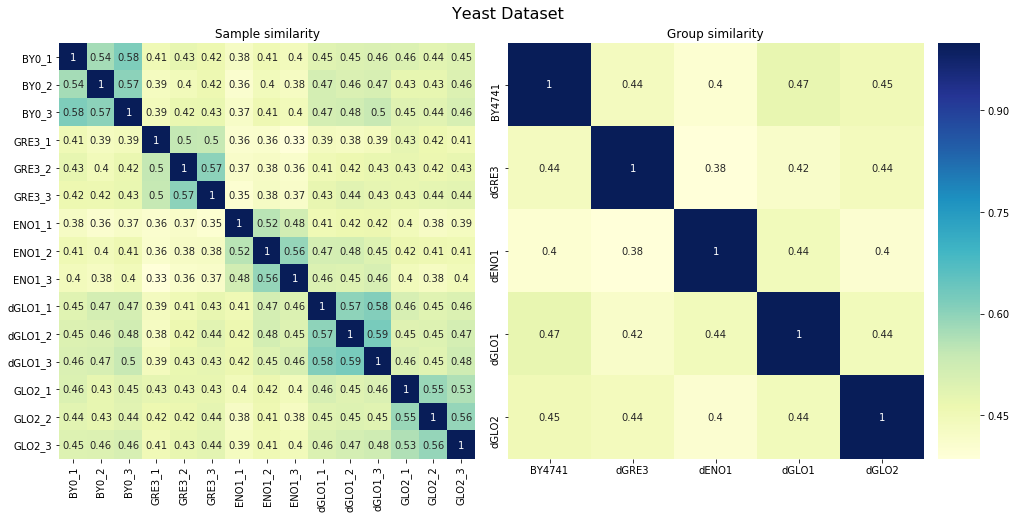

In [17]:
plot_jaccard_sims(Yeast_dfs, 'Yeast Dataset')

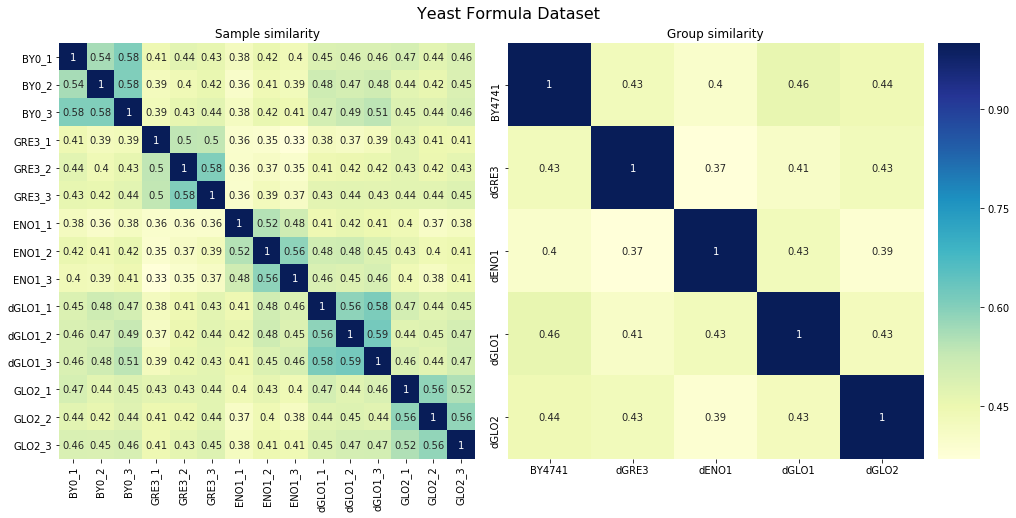

In [18]:
plot_jaccard_sims(Yeast_form_dfs, 'Yeast Formula Dataset')

#### Verification that `dist.pdist()` produces the same result as `mz_similarity()`

In [19]:
intensities = Yeast_dfs['intensities']
bin_01 = Yeast_dfs['binary']

scipy_jdist = dist.pdist(bin_01.T, metric='jaccard')
df_scipy_dist = pd.DataFrame(dist.squareform(scipy_jdist), index=sample_names, columns=sample_names)

sim_YD = mz_similarity(intensities, has_labels=True)
jsim = sim_YD.sample_similarity_jaccard
jdist = 1 - jsim

from pandas.testing import assert_frame_equal
assert_frame_equal(jdist, df_scipy_dist)
# No exception should be raised!

#### Agglomerative Hierarchical Clustering Analysis made with Group Similarity

Dendrogram from Jaccard distance, Yeast Dataset(cophenetic = 0.81413)


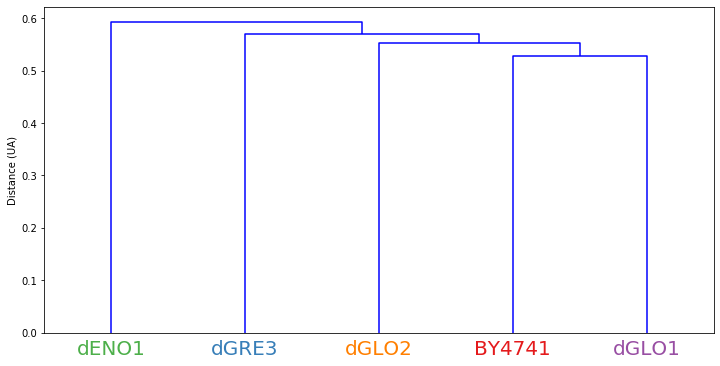

In [20]:
# Calculating the Jaccard distance matrix (between the samples) of the dataset and build the linkage matrix of the HCA
jdist = dist.squareform(1 - sim_YD.label_similarity_jaccard.values)
Z = hier.linkage(jdist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z,jdist)[0]
print(f'Dendrogram from Jaccard distance, Yeast Dataset(cophenetic = {coph:.5f})')

# Plot the dendrogram
fig = plt.figure(figsize=(12,6))
dn = hier.dendrogram(Z, labels=unique_labels, leaf_font_size=20, above_threshold_color='b')

# Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

# Unsupervised Statistical Analysis - YD and YFD

## (Agglomerative) Hierarchical Cluster Analysis 

HCA analysis and plotting dendrograms of each differently-treated dataset.

Dendrograms were plotted with Euclidian distance metric and UPGMA linkage for datasets treated with traditional pre-treatments.

Dendrograms were plotted with different binary distance metrics (Jaccard as example) and UPGMA linkage for datasets treated with BinSim.

In [21]:
def plot_dendogram(Z, title='', color_threshold=None):
    """Plot a dendrogram from a Z linkage matrix with a chosen title and a chosen color_threshold."""
    
    plt.rcParams['lines.linewidth'] = 1.3
    
    fig = plt.figure(figsize=(10,6))
    dn = hier.dendrogram(Z, labels=all_labels, leaf_font_size=13, above_threshold_color='b', leaf_rotation=30,
                         color_threshold=color_threshold)#,  orientation='left')
    
    # Coloring labels
    ax = plt.gca()
    ax.set_ylabel('Distance (UA)')
    ax.set_title(title, fontsize = 16)
    xlbls = ax.get_xmajorticklabels()

    for lbl in xlbls:
        lbl.set_color(label_colors[lbl.get_text()])

## YD - Dendrograms of each differently-treated YD - MetaboScape Normalization (MSNorm)

Feature appears at least in 2 samples of the 15 samples in the dataset. YD in figures where it appears with YFD.

Dataset normalized by MetaboScape.

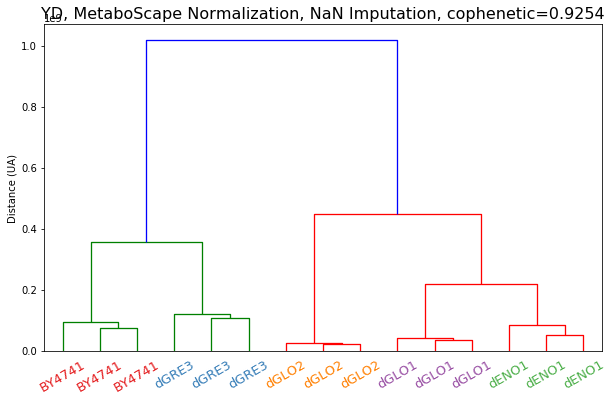

In [22]:
# MetaboScape Normalization (Ref. feature), Missing Value Imputation only
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
Imp_YD = Yeast_dfs['Ionly']
dist_Imp_YD = dist.pdist(Imp_YD.T, metric='euclidean')
Z_Imp_YD = hier.linkage(dist_Imp_YD, method='average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_YD, dist_Imp_YD)[0]

# Plot the dendrogram
title = f'YD, MetaboScape Normalization, NaN Imputation, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_YD, title)

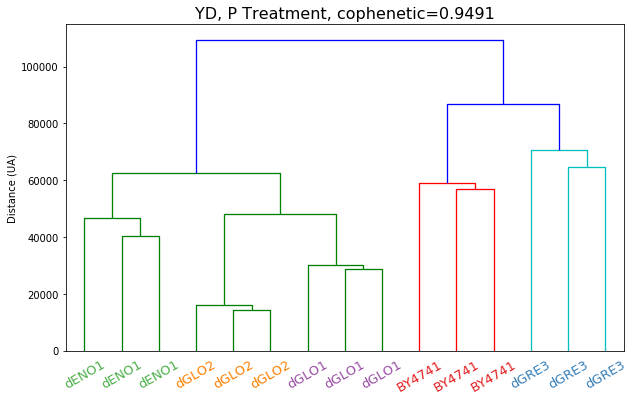

In [23]:
# MetaboScape Normalization (Ref. feature), Imputed and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
P_YD = Yeast_dfs['P']
dist_P_YD = dist.pdist(P_YD.T, metric = 'euclidean')
Z_P_YD = hier.linkage(dist_P_YD, method='average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_YD, dist_P_YD)[0]

# Plot the dendrogram
title = f'YD, P Treatment, cophenetic={coph:.4f}'
plot_dendogram(Z_P_YD, title)

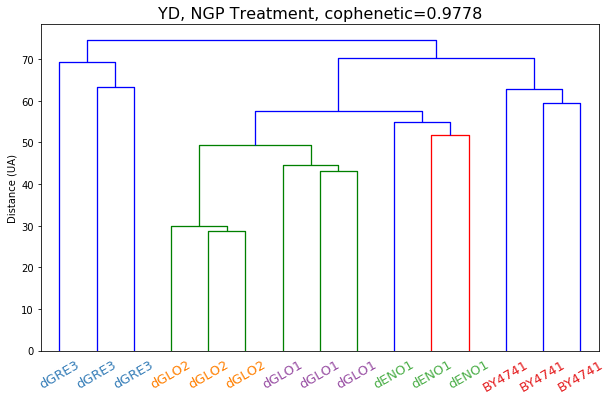

In [24]:
# MetaboScape Normalization (Ref. feature), Imputed, glog transformed and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
NGP_YD = Yeast_dfs['NGP']
dist_NGP_YD = dist.pdist(NGP_YD.T, metric='euclidean')
Z_NGP_YD = hier.linkage(dist_NGP_YD, method='average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_YD,dist_NGP_YD)[0]

# Plot the Dendrogram
title = f'YD, NGP Treatment, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_YD, title)

### Binary Similarity (BinSim) Pre-Treatment - Example Dendogram with Jaccard Dissimilarity (YD)

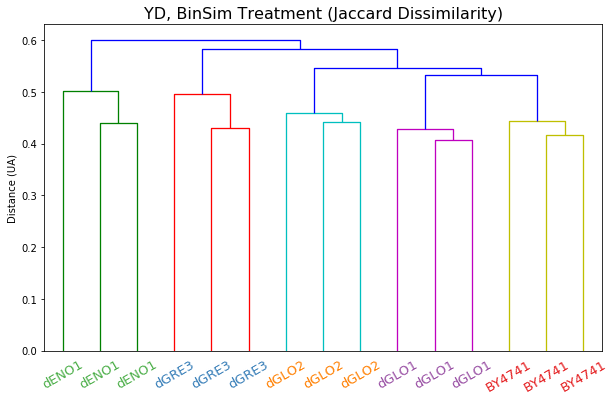

In [25]:
# BinSim
binary = Yeast_dfs['binary']

# Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
Z_bin = hier.linkage(binary.T, metric='jaccard', method='average')

# Plot the dendrogram
title = f'YD, BinSim Treatment (Jaccard Dissimilarity)'
plot_dendogram(Z_bin, title, color_threshold=0.52)

## YFD - Dendrograms of each differently-treated YFD - MetaboScape Normalization (MSNorm)

Feature appears at least in 2 samples of the 15 samples in the dataset. YFD in figures where it appears with YD.

Dataset normalized by MetaboScape.

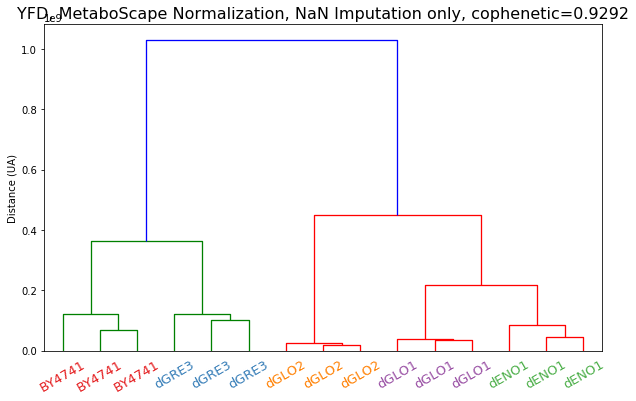

In [26]:
# MetaboScape Normalization (Ref. feature),Missing Value Imputation only
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
Imp_YFD = Yeast_form_dfs['Ionly']
dist_Imp_YFD = dist.pdist(Imp_YFD.T, metric = 'euclidean')
Z_Imp_YFD = hier.linkage(dist_Imp_YFD, method='average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_YFD,dist_Imp_YFD)[0]

# Plot the dendrogram
title = f'YFD, MetaboScape Normalization, NaN Imputation only, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_YFD, title)

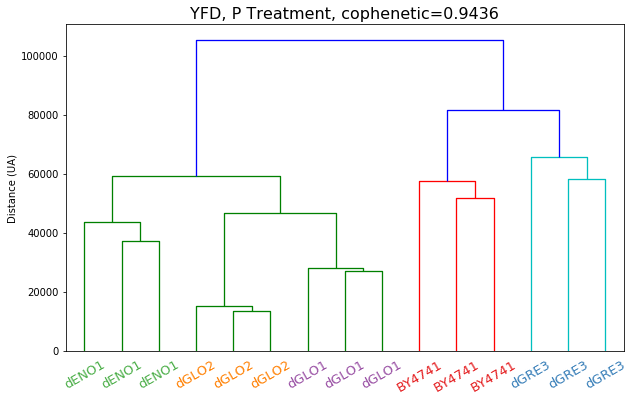

In [27]:
# MetaboScape Normalization (Ref. feature), Imputed and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
P_YFD = Yeast_form_dfs['P']
dist_P_YFD = dist.pdist(P_YFD.T, metric = 'euclidean')
Z_P_YFD = hier.linkage(dist_P_YFD, method='average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_YFD, dist_P_YFD)[0]

# Plot the dendrogram
title = f'YFD, P Treatment, cophenetic={coph:.4f}'
plot_dendogram(Z_P_YFD, title)

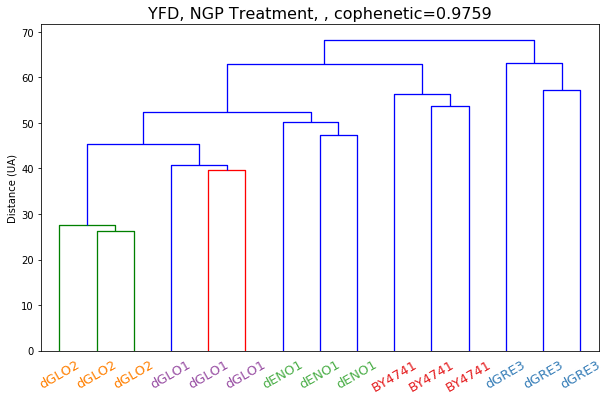

In [28]:
# MetaboScape Normalization (Ref. feature), Imputed, Normalized (reference feature), glog transformed and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
NGP_YFD = Yeast_form_dfs['NGP']
dist_NGP_YFD = dist.pdist(NGP_YFD.T, metric='euclidean')
Z_NGP_YFD = hier.linkage(dist_NGP_YFD, method='average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_YFD, dist_NGP_YFD)[0]

# Plot the dendrogram
title = f'YFD, NGP Treatment, , cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_YFD, title, color_threshold=40)

### Binary Similarity (BinSim) Pre-Treatment - Example Dendogram with Jaccard Dissimilarity (YFD)

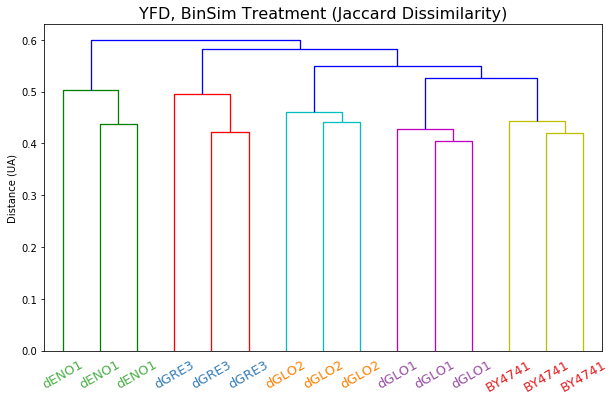

In [29]:
# BinSim
binary = Yeast_form_dfs['binary']

# Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
Z_bin = hier.linkage(binary.T, metric='jaccard', method='average')

# Plot the dendrogram
title = f'YFD, BinSim Treatment (Jaccard Dissimilarity)'
plot_dendogram(Z_bin, title, color_threshold=0.52)

### Similarity Comparison of the dendrograms made with all binary metrics and euclidean distances from the differently-treated datasets

#### Two methods: Cophenetic Correlation Coefficient and Baker's Gamma Correlation Coefficient

Baker's Gamma Correlation: Use of the `mergerank` function from multianalysis.py to create a 'rank' of the iteration number two samples were linked to the same cluster. Then see Kendall Correlation between the results from 2 dendrograms according to Baker's paper (Spearman Correlation according to R package 'dendextend').

Correlation Cophenetic Correlation: Pearson Correlation of the matrix of cophenetic distances of two different dendrograms.

### Traditionally-Treated Datasets - First Part (Until calculating correlations between dendrograms) of calculating the similarity coefficients

In [30]:
# Linkage Matrices of the different dendrograms built from the differently-treated datasets
Est_Treat_Z = (Z_Imp_YD, Z_P_YD, Z_NGP_YD, Z_Imp_YFD, Z_P_YFD, Z_NGP_YFD)

# Condensed distance matrices between samples for each of the differently-treated datasets
dist_Est_Treat = (dist_Imp_YD, dist_P_YD, dist_NGP_YD, dist_Imp_YFD, dist_P_YFD, dist_NGP_YFD)

# Store results for the two metrics
K_BG = [] # Store mergerank results
S_BG = [] # For Baker's Gamma Correlation Coefficient
Coph_C = [] # For Cophenetic Correlation Coefficient

for i, (eu, d) in enumerate(zip(Est_Treat_Z, dist_Est_Treat)):
    K_BG.append(ma.mergerank(eu)) # Mergerank
    S_BG.append(K_BG[i][K_BG[i]!=0]) # Both reshape to a 1D array (needed for spearman correlation) and take out 0s 
    
    Coph_C.append(hier.cophenet(eu, d)) # Matrix of Cophenetic distances

#### Examples of procedure with these methods with the Yeast Dataset - Normalization by MetaboScape

#### Cophenetic Correlation Coefficient

In [31]:
print('Pair of samples      \tPearson Correlation \tp-value')
print('Imp Treat-P Treat   \t', stats.pearsonr(Coph_C[0][1],Coph_C[1][1])[0], '\t', stats.pearsonr(Coph_C[0][1],Coph_C[1][1])[1])
print('Imp Treat-NGP Treat\t', stats.pearsonr(Coph_C[0][1],Coph_C[2][1])[0], '\t', stats.pearsonr(Coph_C[0][1],Coph_C[2][1])[1])

Pair of samples      	Pearson Correlation 	p-value
Imp Treat-P Treat   	 0.9103218453518863 	 2.983812032298868e-41
Imp Treat-NGP Treat	 0.713225873893961 	 1.3870526513170369e-17


#### Baker's Gamma Correlation Coefficient

According to Original Paper (Stability of Two Hierarchical Grouping Techniques Case 1: Sensitivity to Data Errors)

In [32]:
print('Pair of samples      \tKendall Correlation \tp-value')
print('Imp Treat-P Treat   \t', stats.kendalltau(S_BG[0],S_BG[1])[0], '\t', stats.kendalltau(S_BG[0],S_BG[1])[1])
print('Imp Treat-NGP Treat\t', stats.kendalltau(S_BG[0],S_BG[2])[0], '\t', stats.kendalltau(S_BG[0],S_BG[2])[1])

Pair of samples      	Kendall Correlation 	p-value
Imp Treat-P Treat   	 0.7920505396156882 	 2.587411368337444e-43
Imp Treat-NGP Treat	 0.524947529104374 	 1.5116315686103824e-20


According to the explanation given in the R package dendextend

In [33]:
print('Pair of samples      \tSpearman Correlation \tp-value')
print('Imp Treat-P Treat   \t', stats.spearmanr(S_BG[0],S_BG[1])[0], '\t', stats.spearmanr(S_BG[0],S_BG[1])[1])
print('Imp Treat-NGP Treat\t', stats.spearmanr(S_BG[0],S_BG[2])[0], '\t', stats.spearmanr(S_BG[0],S_BG[2])[1])

Pair of samples      	Spearman Correlation 	p-value
Imp Treat-P Treat   	 0.9093678046304186 	 3.5736583585311486e-81
Imp Treat-NGP Treat	 0.6377481669796734 	 2.2572148774456796e-25


### BinSim-Treated Datasets - First Part (Until calculating correlations between dendrograms) of calculating the similarity coefficients

Also building linkage matrices (HCA) using all different binary distance metrics.

Change between number of binary metrics to use.

In [34]:
# New denomination of BinSim treated datasets 
bin_YD = Yeast_dfs['binary']
bin_YFD = Yeast_form_dfs['binary']

In [35]:
# 9 binary methods accepted in pdist (scipy.spatial.distances.pdist)
binary = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 'yule', 'kulsinski', 'russellrao')
# 3 methods that will be used as representative of the others (others not present have similar variations to one of those 3)
#binary = ( 'jaccard', 'hamming', 'yule')

Application of all "single" steps needed to build linkage matrix and get results to apply the correlation metrics.

In [36]:
# Yeast Dataset - Normalization by MetaboScape
Z_YD = [] # Build Linkage matrix (HCA)
K_YD = []
S_YD = []
Coph_YD = []

# Apply for each of the binary distance metrics
for i in range(len(binary)):
    Z_YD.append(hier.linkage(bin_YD.T, metric = binary[i], method='average')) # Z (linkage matrix)
    K_YD.append(ma.mergerank(Z_YD[i])) # Mergerank
    S_YD.append(K_YD[i][K_YD[i]!=0]) # Eliminating 0s
    Coph_YD.append(hier.cophenet(Z_YD[i], dist.pdist(bin_YD.T, metric = binary[i]))) # Matrix of Cophenetic distances

In [37]:
# Yeast Formula Dataset - Normalization by MetaboScape
Z_YFD = []  # Build Linkage matrix (HCA)
K_YFD = []
S_YFD = []
Coph_YFD = []

# Apply for each of the binary distance metrics
for i in range(len(binary)):
    Z_YFD.append(hier.linkage(bin_YFD.T, metric = binary[i], method='average')) # Z (linkage matrix)
    K_YFD.append(ma.mergerank(Z_YFD[i])) # Mergerank
    S_YFD.append(K_YFD[i][K_YFD[i]!=0]) # Eliminating 0s
    Coph_YFD.append(hier.cophenet(Z_YFD[i], dist.pdist(bin_YFD.T, metric = binary[i]))) # Matrix of Cophenetic distances

### Calculating the correlation between the dendrograms - Last step, calculate each pairwise correlation

Choose what set of linkage matrices (one for each differently-treated dataset) to consider when calculating similarity between them.

Here, we will show two sets of heatmaps that mimic the figures presented in the dissertatio: one with the YD and one with the YFD, both with only 3 different binary distance metrics - Jaccard, Hamming and Yule.

As for the Baker's Gamma Correlation, the heatmaps presented will be the ones with corellation calculated with Kendall correlation (according to the original paper - Baker FB. Stability of Two Hierarchical Grouping Techniques Case 1: Sensitivity to Data Errors. J Am Stat Assoc. 1974;69(346):440-445. doi:10.2307/2285675). 

### YD (with 3 different binary distance metrics) - Normalization by MetaboScape

In [38]:
# Creation of a list with all the "rank" values (in order) for the different metrics: 
S = S_BG[:3] + list((S_YD[2],) + (S_YD[1],) + (S_YD[6],))
#S = S_BG[:3] + S_YD

# Creation of a list with all the returns from the function cophenetic for the different metrics: 
Coph = Coph_C[:3] + list((Coph_YD[2],) + (Coph_YD[1],) + (Coph_YD[6],))
#Coph = Coph_C[:3] + Coph_YD

Creation of all dataframes needed to store all correlation coeficients and respective p-values for all three methods

In [39]:
# Column names and row names for the dataframes and heatmaps
colnames = ['Imp', 'P', 'NGP', 'Jaccard', 'Hamming', 'Yule']

In [40]:
nS = len(S)
correlations = {key: np.zeros((nS,nS)) for key in ('K', 'S', 'C', 'K_p', 'S_p', 'C_p')}

# Calculation of correlation coefficient for each method
for i in range(nS):
    for j in range(nS):
        Si, Sj = S[i],S[j]
        # K - Kendall (Baker's Gamma)
        ktau = stats.kendalltau(Si,Sj)
        correlations['K'][i,j], correlations['K_p'][i,j] = ktau
        # S - Spearman (Baker's Gamma)
        spearmanr = stats.stats.spearmanr(Si,Sj)
        correlations['S'][i,j], correlations['S_p'][i,j] = spearmanr
        # C - Cophenetic Correlation Coefficient
        coph = stats.pearsonr(Coph[i][1],Coph[j][1])
        correlations['C'][i,j], correlations['C_p'][i,j] = coph

for k in correlations:
    correlations[k] = pd.DataFrame(correlations[k], columns=colnames, index=colnames)

In [41]:
# Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,nS))* np.nan, columns=colnames, index=[''])
lineV = pd.concat([line.iloc[:,:3], pd.DataFrame(np.empty((1,1))* np.nan, columns =[''], index = ['']),
                   line.iloc[:,3:]], axis = 1)

def prepare_corr_df(df):
    prep = pd.concat([df.iloc[:3], line, df.iloc[3:]])
    prep = pd.concat([prep.iloc[:,:3], lineV.T, prep.iloc[:,3:]], axis = 1)
    return prep

df_KI = prepare_corr_df(correlations['K'])
df_SI = prepare_corr_df(correlations['S'])
df_CI = prepare_corr_df(correlations['C'])

#### Heatmaps of the correlation coeficients for the 2 metrics - Normalization by MetaboScape

Baker's Gamma (Kendall) Correlation Coefficient Heatmap of the differently treated Yeast Dataset - Normalization by MetaboScape
Peak filtering requiring that a feature appears in at least 2 samples of all samples.


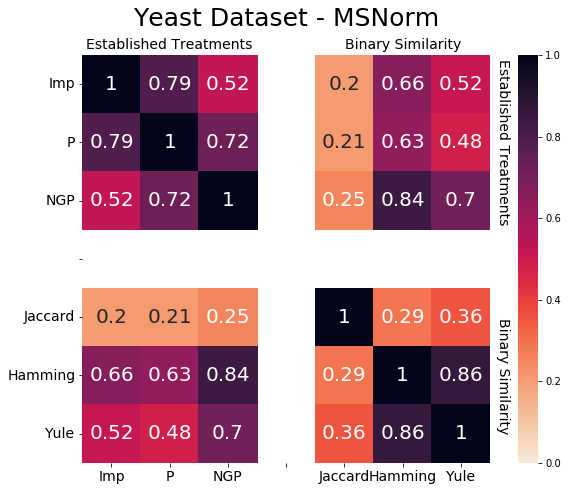

In [42]:
# Plotting the heatmap and adjusting parameters
f, ax = plt.subplots(figsize=(10, 7.5))

print("Baker's Gamma (Kendall) Correlation Coefficient Heatmap of the differently treated Yeast Dataset - Normalization by MetaboScape")
print('Peak filtering requiring that a feature appears in at least 2 samples of all samples.')
hm = sns.heatmap(df_KI, annot=True, ax=ax, square=True, cmap = sns.cm.rocket_r, annot_kws={"size": 20}, vmin=0, vmax=1)
bottom, top = ax.get_ylim()
pos, textvals = plt.yticks()
plt.yticks(np.arange(7)+0.5,(textvals), rotation=0, fontsize="10", va="center")
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.5,-0.1,'Established Treatments', fontsize  = 14, horizontalalignment='center')
plt.text(7.1,1.5,'Established Treatments', fontsize  = 14, rotation = 270, verticalalignment='center')
plt.text(5.5,-0.1,'Binary Similarity', fontsize = 14, horizontalalignment='center')
plt.text(7.1,5.5,'Binary Similarity', fontsize  = 14, rotation = 270, verticalalignment='center')
plt.text(3.5,-0.5,'Yeast Dataset - MSNorm', fontsize  = 25, horizontalalignment='center')
ax.tick_params(labelsize= 14)

plt.show()

Cophenetic Correlation Coefficient Heatmap of the differently treated Yeast Dataset - Normalization by MetaboScape
Peak filtering requiring that a feature appears in at least 2 samples of all samples.


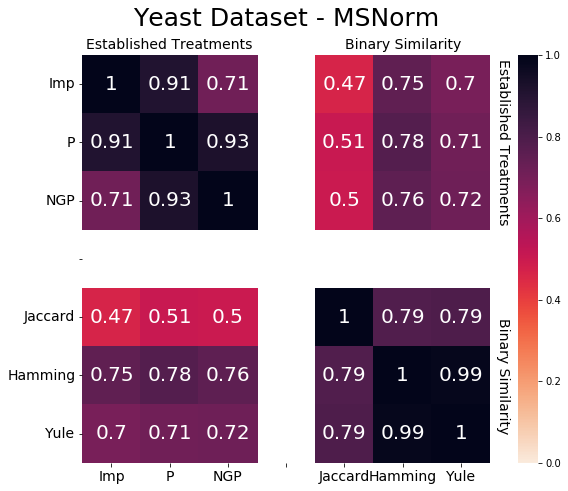

In [43]:
# Plotting the heatmap and adjusting parameters
f, ax = plt.subplots(figsize=(10, 7.5))

print("Cophenetic Correlation Coefficient Heatmap of the differently treated Yeast Dataset - Normalization by MetaboScape")
print('Peak filtering requiring that a feature appears in at least 2 samples of all samples.')
hm = sns.heatmap(df_CI, annot=True, ax=ax, square=True, cmap = sns.cm.rocket_r, annot_kws={"size": 20}, vmin=0, vmax=1)
bottom, top = ax.get_ylim()
pos, textvals = plt.yticks()
plt.yticks(np.arange(7)+0.5,(textvals), rotation=0, fontsize="10", va="center")
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.5,-0.1,'Established Treatments', fontsize  = 14, horizontalalignment='center')
plt.text(7.1,1.5,'Established Treatments', fontsize  = 14, rotation = 270, verticalalignment='center')
plt.text(5.5,-0.1,'Binary Similarity', fontsize = 14, horizontalalignment='center')
plt.text(7.1,5.5,'Binary Similarity', fontsize  = 14, rotation = 270, verticalalignment='center')
plt.text(3.5,-0.5,'Yeast Dataset - MSNorm', fontsize  = 25, horizontalalignment='center')
ax.tick_params(labelsize= 14)

plt.show()

### YFD (with 3 different binary distance metrics) - Normalization by MetaboScape

In [44]:
# Creation of a list with all the "rank" values (in order) for the different metrics: 
S = S_BG[3:] + list((S_YFD[2],) + (S_YFD[1],) + (S_YFD[6],))
#S = S_BG[3:] + S_YFD

# Creation of a list with all the returns from the function cophenetic for the different metrics: 
Coph = Coph_C[3:] + list((Coph_YFD[2],) + (Coph_YFD[1],) + (Coph_YFD[6],))
#Coph = Coph_C[3:] + Coph_YFD

Creation of all dataframes needed to store all correlation coeficients and respective p-values for all three methods

In [45]:
# Column names and row names for the dataframes and heatmaps
colnames = ['Imp', 'P', 'NGP', 'Jaccard', 'Hamming', 'Yule']

In [46]:
nS = len(S)
correlations = {key: np.zeros((nS,nS)) for key in ('K', 'S', 'C', 'K_p', 'S_p', 'C_p')}

# Calculation of correlation coefficient for each method
for i in range(nS):
    for j in range(nS):
        Si, Sj = S[i],S[j]
        # K - Kendall (Baker's Gamma)
        ktau = stats.kendalltau(Si,Sj)
        correlations['K'][i,j], correlations['K_p'][i,j] = ktau
        # S - Spearman (Baker's Gamma)
        spearmanr = stats.stats.spearmanr(Si,Sj)
        correlations['S'][i,j], correlations['S_p'][i,j] = spearmanr
        # C - Cophenetic Correlation Coefficient
        coph = stats.pearsonr(Coph[i][1],Coph[j][1])
        correlations['C'][i,j], correlations['C_p'][i,j] = coph

for k in correlations:
    correlations[k] = pd.DataFrame(correlations[k], columns=colnames, index=colnames)

In [47]:
# Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,nS))* np.nan, columns=colnames, index=[''])
lineV = pd.concat([line.iloc[:,:3], pd.DataFrame(np.empty((1,1))* np.nan, columns =[''], index = ['']),
                   line.iloc[:,3:]], axis = 1)

def prepare_corr_df(df):
    prep = pd.concat([df.iloc[:3], line, df.iloc[3:]])
    prep = pd.concat([prep.iloc[:,:3], lineV.T, prep.iloc[:,3:]], axis = 1)
    return prep

df_KI = prepare_corr_df(correlations['K'])
df_SI = prepare_corr_df(correlations['S'])
df_CI = prepare_corr_df(correlations['C'])

#### Heatmaps of the correlation coeficients for the 2 metrics - Normalization by MetaboScape

Baker's Gamma (Kendall) Correlation Coefficient Heatmap of the differently treated Yeast Formula Dataset- Normalization by MetaboScape
Peak filtering requiring that a feature appears in at least 2 samples of all samples.


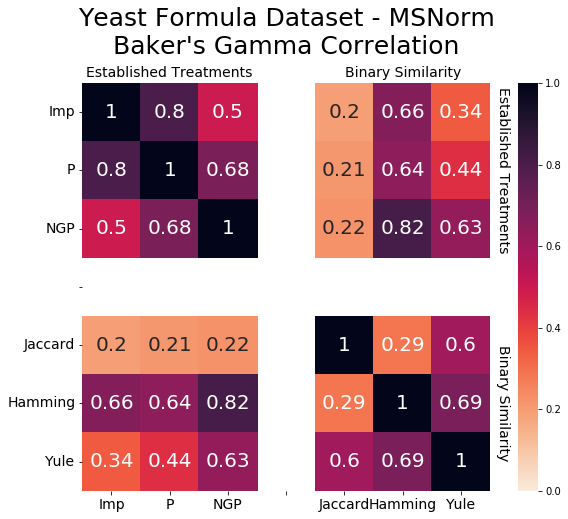

In [48]:
# Plotting the heatmap and adjusting parameters
f, ax = plt.subplots(figsize=(10, 7.5))

print("Baker's Gamma (Kendall) Correlation Coefficient Heatmap of the differently treated Yeast Formula Dataset- Normalization by MetaboScape")
print('Peak filtering requiring that a feature appears in at least 2 samples of all samples.')
hm = sns.heatmap(df_KI, annot=True, ax=ax, square=True, cmap = sns.cm.rocket_r, annot_kws={"size": 20}, vmin=0, vmax=1)
bottom, top = ax.get_ylim()
pos, textvals = plt.yticks()
plt.yticks(np.arange(7)+0.5,(textvals), rotation=0, fontsize="10", va="center")
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.5,-0.1,'Established Treatments', fontsize  = 14, horizontalalignment='center')
plt.text(7.1,1.5,'Established Treatments', fontsize  = 14, rotation = 270, verticalalignment='center')
plt.text(5.5,-0.1,'Binary Similarity', fontsize = 14, horizontalalignment='center')
plt.text(7.1,5.5,'Binary Similarity', fontsize  = 14, rotation = 270, verticalalignment='center')
plt.text(3.5,-0.5,"Yeast Formula Dataset - MSNorm\nBaker's Gamma Correlation", fontsize  = 25, horizontalalignment='center')
ax.tick_params(labelsize= 14)

plt.show()

Cophenetic Correlation Coefficient Heatmap of the differently treated Yeast Dataset - Normalization by MetaboScape
Peak filtering requiring that a feature appears in at least 2 samples of all samples.


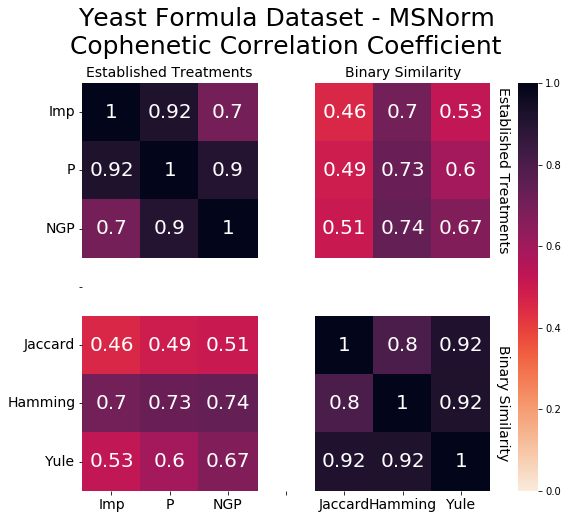

In [49]:
# Plotting the heatmap and adjusting parameters
f, ax = plt.subplots(figsize=(10, 7.5))

print("Cophenetic Correlation Coefficient Heatmap of the differently treated Yeast Dataset - Normalization by MetaboScape")
print('Peak filtering requiring that a feature appears in at least 2 samples of all samples.')
hm = sns.heatmap(df_CI, annot=True, ax=ax, square=True, cmap = sns.cm.rocket_r, annot_kws={"size": 20}, vmin=0, vmax=1)
bottom, top = ax.get_ylim()
pos, textvals = plt.yticks()
plt.yticks(np.arange(7)+0.5,(textvals), rotation=0, fontsize="10", va="center")
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.5,-0.1,'Established Treatments', fontsize  = 14, horizontalalignment='center')
plt.text(7.1,1.5,'Established Treatments', fontsize  = 14, rotation = 270, verticalalignment='center')
plt.text(5.5,-0.1,'Binary Similarity', fontsize = 14, horizontalalignment='center')
plt.text(7.1,5.5,'Binary Similarity', fontsize  = 14, rotation = 270, verticalalignment='center')
plt.text(3.5,-0.5,"Yeast Formula Dataset - MSNorm\nCophenetic Correlation Coefficient", 
         fontsize  = 25, horizontalalignment='center')
ax.tick_params(labelsize= 14)

plt.show()

### Hierarchical clustering of the correlation coeficients of dendrograms made with different distance metrics with each other - Not used in the end

Different colours for the YD treated traditionally, YFD treated traditionally, YD treated with BinSim (different binary distance metrics) and YFD treated with BinSim (different binary distance metrics).

In [50]:
# Creation of a list with all the "rank" values (in order) for the different metrics: 
S = S_BG[:] + S_YD + S_YFD

# Creation of a list with all the returns from the function cophenetic for the different metrics: 
Coph = Coph_C[:] + Coph_YD + Coph_YFD

Creation of all dataframes needed to store all correlation coeficients and respective p-values fot all three methods

In [51]:
# Column names and row names for the dataframes and heatmaps
colnames = ['Imp_YD', 'P_YD', 'NGP_YD', 'Imp_YFD', 'P_YFD', 'NGP_YFD',  'dice_YD', 'hamming_YD', 'jaccard_YD', 
            'rogerstanimoto_YD', 'sokalmichener_YD', 'sokalsneath_YD','yule_YD', 'kulsinski_YD', 'russellrao_YD', 'dice_YFD',
            'hamming_YFD', 'jaccard_YFD', 'rogerstanimoto_YFD', 'sokalmichener_YFD', 'sokalsneath_YFD','yule_YFD', 
            'kulsinski_YFD', 'russellrao_YFD']

In [52]:
nS = len(S)
correlations = {key: np.zeros((nS,nS)) for key in ('K', 'S', 'C', 'K_p', 'S_p', 'C_p')}

# Calculation of correlation coefficient for each method
for i in range(nS):
    for j in range(nS):
        Si, Sj = S[i],S[j]
        # K - Kendall (Baker's Gamma)
        ktau = stats.kendalltau(Si,Sj)
        correlations['K'][i,j], correlations['K_p'][i,j] = ktau
        # S - Spearman (Baker's Gamma)
        spearmanr = stats.stats.spearmanr(Si,Sj)
        correlations['S'][i,j], correlations['S_p'][i,j] = spearmanr
        # C - Cophenetic Correlation Coefficient
        coph = stats.pearsonr(Coph[i][1],Coph[j][1])
        correlations['C'][i,j], correlations['C_p'][i,j] = coph

for k in correlations:
    correlations[k] = pd.DataFrame(correlations[k], columns=colnames, index=colnames)

In [53]:
label_colors2 = {}
colours2 = cm.get_cmap('nipy_spectral', 6)
col_lbl2 = colours2(range(6))
for i in range(2):
    label_colors2[colnames[3*i]] = col_lbl2[i]
    label_colors2[colnames[3*i+1]] = col_lbl2[i]
    label_colors2[colnames[3*i+2]] = col_lbl2[i]
    label_colors2[colnames[3*i+3]] = col_lbl2[i]
for i in range(9):
    label_colors2[colnames[6+i]] = col_lbl2[4]
    label_colors2[colnames[15+i]] = col_lbl2[5]

HCA of the Baker's Gamma (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: Data Pre-treatment or Binary Distance Metric _ YD or YFD


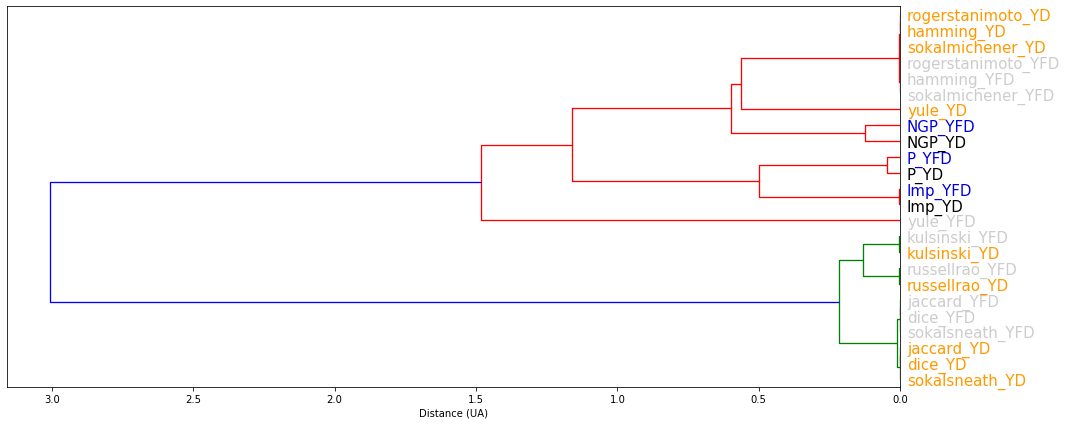

In [54]:
print("HCA of the Baker's Gamma (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics")
print('Name Convention: Data Pre-treatment or Binary Distance Metric _ YD or YFD')
Z_K = hier.linkage(correlations['K'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_K, labels=colnames,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
# Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

HCA of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: Data Pre-treatment or Binary Distance Metric _ YD or YFD


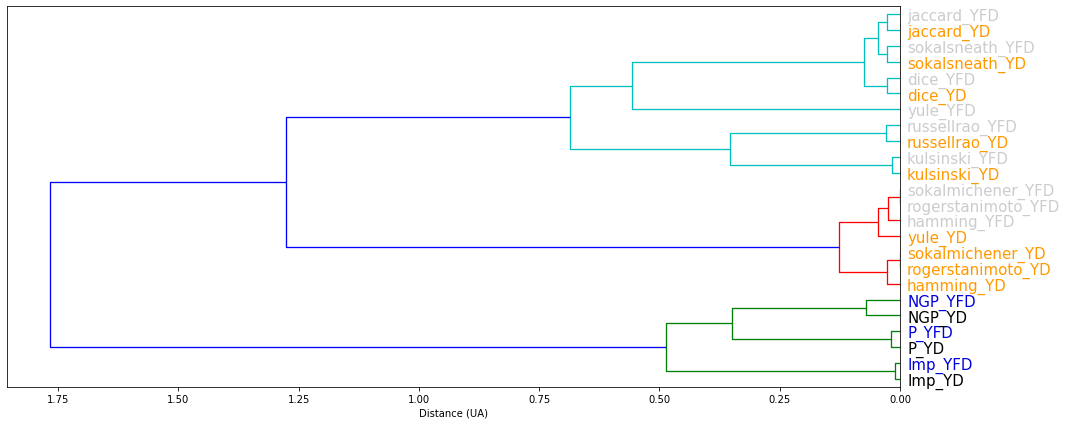

In [55]:
print("HCA of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics")
print('Name Convention: Data Pre-treatment or Binary Distance Metric _ YD or YFD')
Z_C = hier.linkage(correlations['C'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_C, labels=colnames,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

### Comparing HCAs (Dendrograms) Discrimination

Using 3 different metrics explained in the dissertation:

- Discrimination Distance
- Correct Clustering Percentage
- Correct First Cluster

Functions applied here (`dist_discrim` and `correct_1stcluster_fraction`) from multianalysis.py file of this repository with explanations of each step to calculate the different metrics.

Correct (Group) Clustering definition - samples of a group all clustered together before any other sample clustered with a sample of said group.

In [56]:
# Linkage Matrices of the different dendrograms built from the each differently-treated datasets
Z = list(Est_Treat_Z) + Z_YD + Z_YFD

In [57]:
disc_average = np.zeros((1,24)) # Discrimination Distance
disc_correct = np.zeros((1,24)) # Correct Clustering Percentage Storing
disc_1stclust = np.zeros((1,24)) # Correct First Cluster Percentage Storing

for i in range(len(Z)):
    data = Yeast_dfs['intensities']
    
    # Discrimination Distance and Correct Clustering Percentage
    discrim = ma.dist_discrim(data, Z[i], method = 'average')  # all samples have the same order
    disc_average[0,i] = discrim[0]
    #disc_median[0,i] = ma.dist_discrim(data, Z[i], 'median')[0] # all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])
    
    # Correct First Cluster Percentage
    disc_1stclust[0,i] = ma.correct_1stcluster_fraction(data, Z[i]) # all samples have the same order
    
# Transforming results into DataFrames    
disc_average = pd.DataFrame(disc_average, index = ['Discrimination Distance'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct * 100 / 5, index = ['% correct groupings'], columns = colnames) # Transforming into %s
disc_1stclust = pd.DataFrame(disc_1stclust * 100, index = ['% correct 1st cluster'], columns = colnames) # Transforming into %s

# Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['Discrimination Distance']).T, disc_average.iloc[:,6:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['% correct groupings']).T, disc_correct.iloc[:,6:]], axis = 1)
disc_1stclust = pd.concat([disc_1stclust.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['% correct 1st cluster']).T, disc_1stclust.iloc[:,6:]], axis = 1)

#### Representation of the results from the three metrics with heatmaps

Text(16, -0.2, 'Binary Similarity')

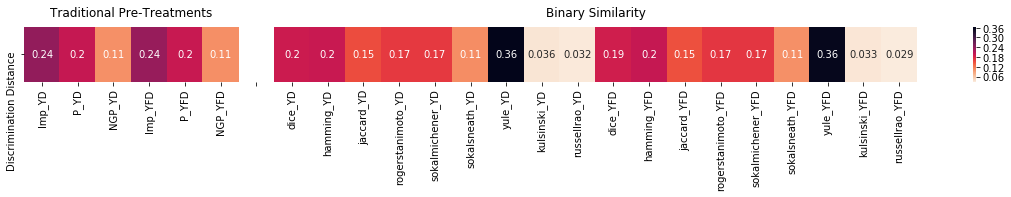

In [58]:
# Discrimination Distance
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.text(3,-0.2,'Traditional Pre-Treatments', fontsize  = 12, horizontalalignment='center')
plt.text(16,-0.2,'Binary Similarity', fontsize = 12, horizontalalignment='center')

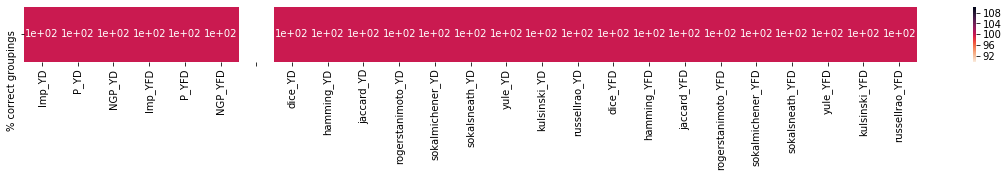

In [59]:
# Correct First Cluster Percentage
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

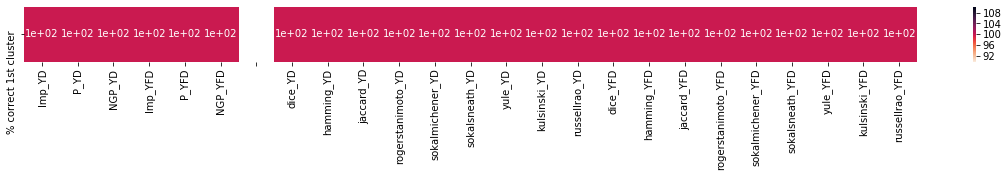

In [60]:
# Correct Clustering Percentage
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_1stclust, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### K-means Clustering Analysis

K-means clustering analysis was applied by using the appropriate functions of the scikit-learn as done in the following cells.

In [61]:
import sklearn.cluster as skclust

#### Example of what happens in a K-means clustering analysis and how samples are separated 

Use of the sci-kit learn Python package - sklearn. 

Cluster number equal to the amount of groups. Default parameters except number of clusters.

K-means clustering analysis has an intrinsically random side to it depending on the starting position of the clusters and existence of local minima.

In [62]:
# Setting the K-means Clustering
Kmean = skclust.KMeans(n_clusters=5)

In [63]:
# Fitting the K-means clustering analysis to a dataset
a = Kmean.fit(NGP_YD.T)
a.inertia_ # Results of the function to be minimized by the K-means algorithm
# sum of squared distances of the samples to the cluster centers

14066.965073654721

In [64]:
# Example of the cluster mades with the K-means clustering analysis. Samples identified by their groups
dicto = {}
#data = Yeast_dfs['intensities']
for i, lbl in enumerate(a.labels_):
    dicto.setdefault(lbl, []).append(all_labels[i])
dicto

{0: ['BY4741', 'BY4741', 'BY4741'],
 2: ['dGRE3', 'dGRE3', 'dGRE3'],
 4: ['dENO1', 'dENO1', 'dENO1'],
 1: ['dGLO1', 'dGLO1', 'dGLO1'],
 3: ['dGLO2', 'dGLO2', 'dGLO2']}

### K-means clustering applied to all euclidean methods and the binary matrixes built - Normalization by MetaboScape

Using 3 different metrics explained in the dissertation:

- Discrimination Distance (for K-means clustering)
- Correct Clustering Percentage (for K-means clustering)
- Adjusted Rand Index (calculated by scikit-learn - `adjusted_rand_index`)

Due to the randomness of the K-means clustering analysis (position of initial cluster centers leading to different local minima), this analysis was iterated 150 times and the 10% of analysis that led to a greater minimization of the objective function - sum of squared distances of the samples to the cluster centers - were chosen to calculate the 3 different metrics mentioned. The Median of the different metrics were taken as the final results.

`Kmeans_discrim` function applied here from multianalysis.py file of this repository with explanations of each step to calculate the different metrics.

Correct clustering definition - K-means Cluster contains all and only the samples of a single group (stricter definition than in HCA).

A method similar to the Discrimination Distance and Correct Clustering percentage performed in the HCA was made. Replicates of a variety can be together in a cluster but, if there are more samples in the same cluster, its "discrimination distance" is still zero and the groups isn't correctly clustered. Therefore, this method is harsher than the Discrimination Distance and Correct Clustering Percentage for HCA.  Thus, the Correct Clustering Percentage is expected to be lower in this case

The Discrimination Distance is calculated as the distance between the centroid of the cluster where the samples are and the closest centroid. It is normalized by dividing it by the maximum distance between any 2 centroids of the clusters formed. The mean of the Discrimination Distances of all groups is then a measure of the global Discrimination Distance. 

In [65]:
colnames2 = ['Imp_YD', 'P_YD', 'NGP_YD', 'BinSim_YD', 'Imp_YFD', 'P_YFD','NGP_YFD', 'BinSim_YFD']

In [66]:
# Datasets to apply the K-means Clustering Analysis
Data = (Imp_YD, P_YD, NGP_YD, bin_YD, Imp_YFD, P_YFD, NGP_YFD, bin_YFD)

In [67]:
disc_average = np.zeros((1,8)) # Discrimination Distance
disc_correct = np.zeros((1,8)) # Correct Clustering Percentage
disc_rand = np.zeros((1,8)) # Adjusted Rand Index

for i in range(len(Data)):
    # Applying Kmeans_discrim function 150 times, taking the best 10% and measuring the Discrimination Distance, Correct
    # Clustering percentage and adjusted Rand Index metrics to evaluate the discrimination.
    discrim = ma.Kmeans_discrim(Data[i], method = 'average', iter_num=150, best_fraction=0.1)
    
    # Lists for the results of the best k-means clustering
    average = []
    correct = []
    rand = []
    for j in discrim:
        average.append(discrim[j][0]) # Discrimination Distances
        all_correct = np.array(list(discrim[j][1].values()))
        correct.append(len(all_correct[all_correct>0])) # Correct Clustering Percentages
        rand.append(discrim[j][2]) # Adjusted Rand Index
    
    # Putting results into the arrays - median of the best k-means clustering
    disc_average[0,i] = np.median(average) 
    disc_correct[0,i] = np.median(correct)
    disc_rand[0,i] = np.median(rand)

# Transforming into DataFrame
disc_average = pd.DataFrame(disc_average, index = ['Discrimination Distance'], columns = colnames2)
disc_correct = pd.DataFrame(disc_correct * 100 / 5, index = ['% correct groupings'], columns = colnames2) # Transforming into %s
disc_rand = pd.DataFrame(disc_rand, index = ['Rand Index'], columns = colnames2)

#### K-means Clustering Analysis Results

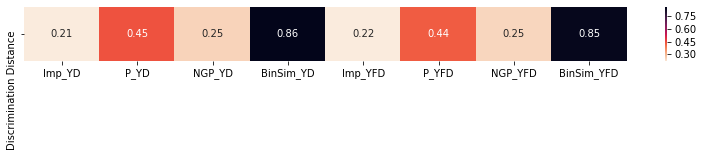

In [68]:
# Discrimination Distance
f, ax = plt.subplots(figsize=(13.5, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)

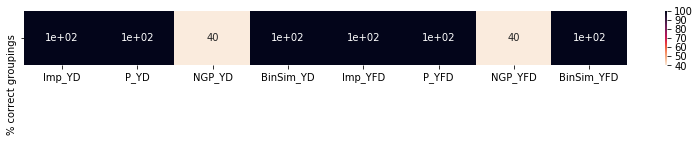

In [69]:
# Correct Clustering Percentage
f, ax = plt.subplots(figsize=(13.5, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

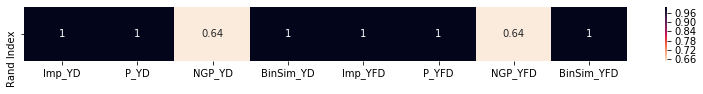

In [70]:
# Adjusted Rand Index
f, ax = plt.subplots(figsize=(13.5, 1))
hm = sns.heatmap(disc_rand, annot=True, ax=ax, cmap = sns.cm.rocket_r)

## Supervised Statistical Analysis

The Supervised Statistical Analysis methods used will be Random Forest and PLS-DA. The performance of the models/classifiers built will be evaluated by their predictive accuracy (which will always be estimated by internal stratified 3-fold cross-validation).

Internal stratified 3-fold cross-validation was used to estimate the model's performance since that is maximum number possible since every group of samples only has 3 replicates in the dataset.

The datasets that will be analyzed (differently-treated Yeast and Yeast Formula Datasets pre-normalized by MetaboScape):

In [71]:
# Centralize data information in a dictionary
datasets = {}

datasets['Imp_YD'] = Yeast_dfs['Ionly']
datasets['P_YD'] = Yeast_dfs['P']
datasets['NGP_YD'] = Yeast_dfs['NGP']
datasets['BinSim_YD'] = Yeast_dfs['binary']

datasets['Imp_YFD'] = Yeast_form_dfs['Ionly']
datasets['P_YFD'] = Yeast_form_dfs['P']
datasets['NGP_YFD'] = Yeast_form_dfs['NGP']
datasets['BinSim_YFD'] = Yeast_form_dfs['binary']

## Random Forests - YD and YFD normalized by MetaboScape

### Test number of trees needed for predictive accuracy convergence for Imp, P, NGP and BinSim treated data

Random Forest models with different number of trees will be built to assess when the predictive accuracy of the different models stops increasing with higher number of trees.

Grid search of number of trees from 10 to 200 for the random forests. See where the cross-validation estimated predictive accuracy stops improving for each one.

#### Takes  some time

In [72]:
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble

# Vector with values for the parameter n_estimators
values = {'n_estimators': range(10,200,2)} # Models will be built from 10 to 200 trees in 2 tree intervals

rf = skensemble.RandomForestClassifier(n_estimators=200)
clf = GridSearchCV(rf, values, cv=3)

In [73]:
# For each dataset,building the Random Forest models with the different number of trees
# and storing the predictive accuracy (estimated by 3-fold cross-validation)
param = []
test_score = []
for name, dataset in datasets.items():
    print('Fitting', name, '...', end=' ')
    clf.fit(dataset.T, all_labels)
    param.append(clf.cv_results_['param_n_estimators'])
    test_score.append(clf.cv_results_['mean_test_score'])
    print('Done!')

Fitting Imp_YD ... Done!
Fitting P_YD ... Done!
Fitting NGP_YD ... Done!
Fitting BinSim_YD ... Done!
Fitting Imp_YFD ... Done!
Fitting P_YFD ... Done!
Fitting NGP_YFD ... Done!
Fitting BinSim_YFD ... Done!


Performance (Predictive Accuracy) based on number of trees - Yeast Dataset


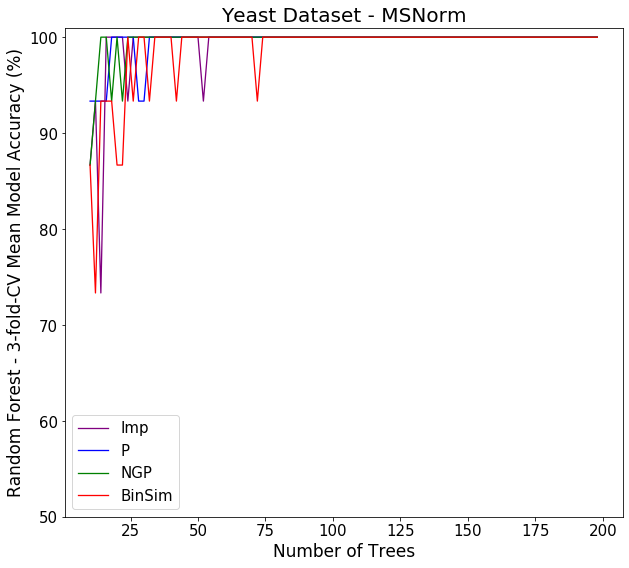

In [74]:
# Plotting the results and adjusting parameters of the plot
f, ax = plt.subplots(figsize=(10,9))

color = ['purple','blue','green','red']
for i in range(4):
    plt.plot(param[i], test_score[i]*100, color=color[i])

plt.ylabel('Random Forest - 3-fold-CV Mean Model Accuracy (%)', fontsize = 17)
plt.xlabel('Number of Trees', fontsize = 17)
ax.legend(('Imp', 'P', 'NGP', 'BinSim'), fontsize=15)
plt.ylim(50,101)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.title('Yeast Dataset - MSNorm', fontsize=20)
print('Performance (Predictive Accuracy) based on number of trees - Yeast Dataset')

Performance (Predictive Accuracy) based on number of trees - Yeast Formula Dataset


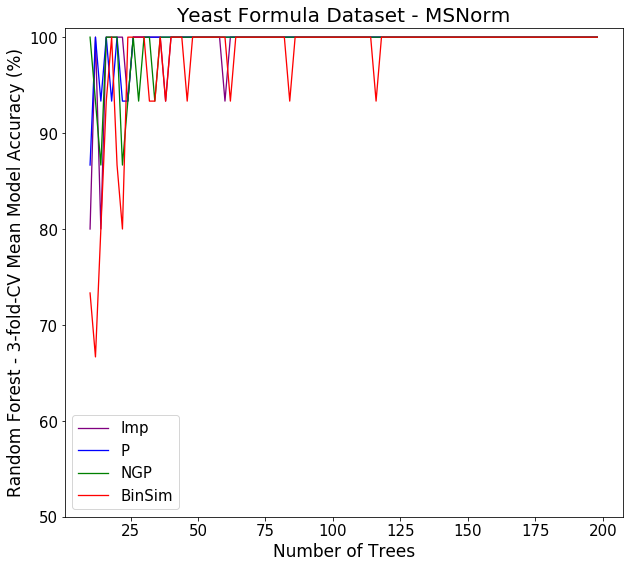

In [75]:
f, ax = plt.subplots(figsize=(10,9))

color = ['purple','blue','green','red']
for i in range(4,8):
    plt.plot(param[i], test_score[i]*100, color = color[i-4])

plt.ylabel('Random Forest - 3-fold-CV Mean Model Accuracy (%)', fontsize = 17)
plt.xlabel('Number of Trees', fontsize = 17)
plt.ylim([50,101])
ax.legend(('Imp', 'P', 'NGP', 'BinSim'), fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.title('Yeast Formula Dataset - MSNorm', fontsize=20)
print('Performance (Predictive Accuracy) based on number of trees - Yeast Formula Dataset')

### Random Forest Application

Stores predictive accuracy of the models, standard deviation of the predictive accuracy (across the iterations) and an ordered list of the most to least important features (average across the iterations) in building the model according to the Gini Importance calculated by scikit-learn (all estimated by stratified 3-fold cross-validation) of each of the 200 iterations (with different samplings of the 3 folds) of models built for each secondary dataset.

Iterations are made to randomly sample the folds in 3-fold cross-validation - more combinations of training and test samples are used to offset the small (in terms of samples per group) dataset.

Use of the `simple_RF` function of multianalysis.py (uses Random Forest algorithm from scikit-learn) where each step of the process is better explained.

In [76]:
# Preparations of dicts:
Scores = {} # Stores Predictive Accuracy
Scores_std = {} # Stores Predictive Accuracy's Standard Deviation
Imp_feat = {} # Stores ordered list of most to least important feature to build the model

# Application of the Random Forests for each differently-treated dataset
for name, data in datasets.items():
    print(f'Fitting random forest for {name} ...', end='')
    rf, imp_features = ma.simple_RF(data, iter_num=200)
    Scores[name] = rf
    Scores_std[name] = np.std(rf)
    Imp_feat[name] = imp_features
    print(f'done')    

Fitting random forest for Imp_YD ...done
Fitting random forest for P_YD ...done
Fitting random forest for NGP_YD ...done
Fitting random forest for BinSim_YD ...done
Fitting random forest for Imp_YFD ...done
Fitting random forest for P_YFD ...done
Fitting random forest for NGP_YFD ...done
Fitting random forest for BinSim_YFD ...done


#### Results of the Random Forests - Performance (Predictive Accuracy) 

Predictive Accuracy of Random Forest models - Yeast Dataset - MSNorm


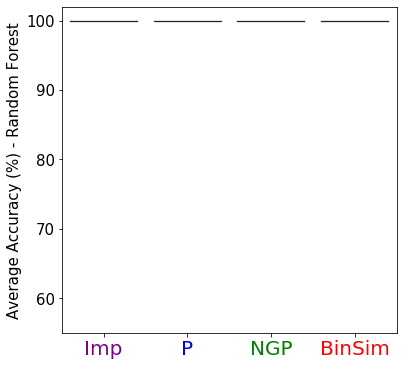

In [77]:
# Violin plot of the distribution of the predictive accuracy (in %) across 200 iterations of randomly sampled folds for each 
# differently-treated dataset and adjustments to the parameters of the plot.
f, ax = plt.subplots(figsize=(6,6))

# Select only data from the Yeast Dataset
data = pd.DataFrame.from_dict(Scores).iloc[:,:4] * 100

data.columns = ['Imp', 'P', 'NGP', 'BinSim']
colors = ['purple','blue','green','red']
sns.violinplot( data = data, palette = colors*2, alpha = 0.5)
plt.ylabel('Average Accuracy (%) - Random Forest', fontsize = 15)
plt.ylim([55,102])
ax.tick_params(axis='x', which='major', labelsize = 20)
ax.tick_params(axis='y', which='major', labelsize = 15)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)

print('Predictive Accuracy of Random Forest models - Yeast Dataset - MSNorm')

Predictive Accuracy of Random Forest models - Yeast Formula Dataset - MSNorm


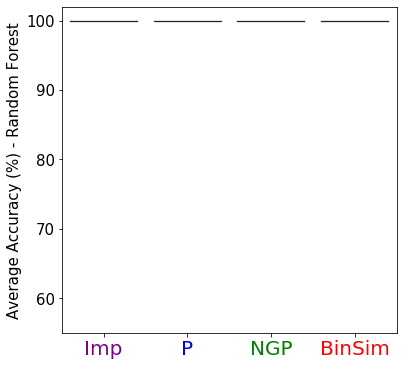

In [78]:
# Violin plot of the distribution of the predictive accuracy (in %) across 200 iterations of randomly sampled folds for each 
# differently-treated dataset and adjustments to the parameters of the plot.
f, ax = plt.subplots(figsize=(6,6))

# Select only data from the Yeast Formula Dataset
data = pd.DataFrame.from_dict(Scores).iloc[:,4:] * 100

data.columns = ['Imp', 'P', 'NGP', 'BinSim']
colors = ['purple','blue','green','red']
sns.violinplot( data = data, palette = colors*2, alpha = 0.5)
plt.ylabel('Average Accuracy (%) - Random Forest', fontsize = 15)
plt.ylim([55,102])
ax.tick_params(axis='x', which='major', labelsize = 20)
ax.tick_params(axis='y', which='major', labelsize = 15)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)
#plt.savefig('RF-YFD')
print('Predictive Accuracy of Random Forest models - Yeast Formula Dataset - MSNorm')

#### Extra Info

In [79]:
# Average prediction accuracy (and standard deviation of the predictive accuracy) of the models built for each of the
# differently-treated datasets estimated by stratified 3-fold cross validation
Scores_A = {}
for i in Scores:
    Scores_A[i] = np.mean(Scores[i])

Scores_H = pd.DataFrame(list(Scores_A.values()), index = Scores_A.keys()).T
Scores_std_H = pd.DataFrame(list(Scores_std.values()), index = Scores_std.keys()).T

In [80]:
# Plotting the results
#f, ax = plt.subplots(figsize=(10, 1))
#hm = sns.heatmap(Scores_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_Scores'])
Scores_H

,Imp_YD,P_YD,NGP_YD,BinSim_YD,Imp_YFD,P_YFD,NGP_YFD,BinSim_YFD
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


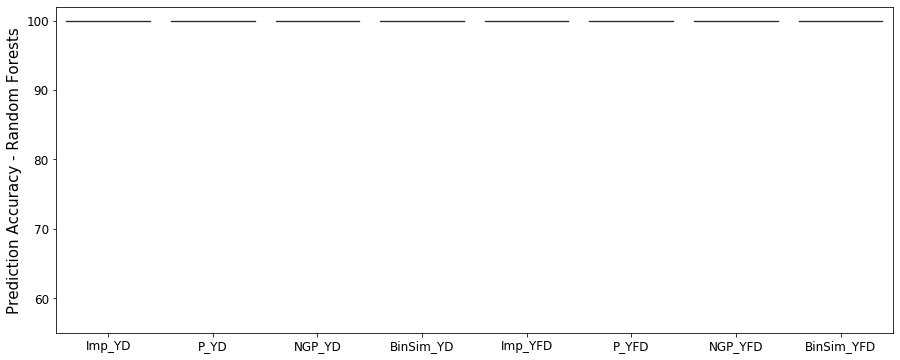

In [81]:
# Violin plot of the distribution of the predictive accuracy (in %) across 200 iterations of randomly sampled folds for all 
# differently-treated dataset
f, ax = plt.subplots(figsize=(15,6))
colors = ['purple','blue','green','red','purple','blue','green','red']
data = pd.DataFrame.from_dict(Scores)*100
plt.ylim([55,102])
sns.violinplot(data = data, palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - Random Forests', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 12)

In [82]:
Scores_H = pd.DataFrame(list(Scores_A.values()), index = Scores_A.keys(), columns = ['Accuracy']).T
Scores_std_H = pd.DataFrame(list(Scores_std.values()), index = Scores_A.keys()).T

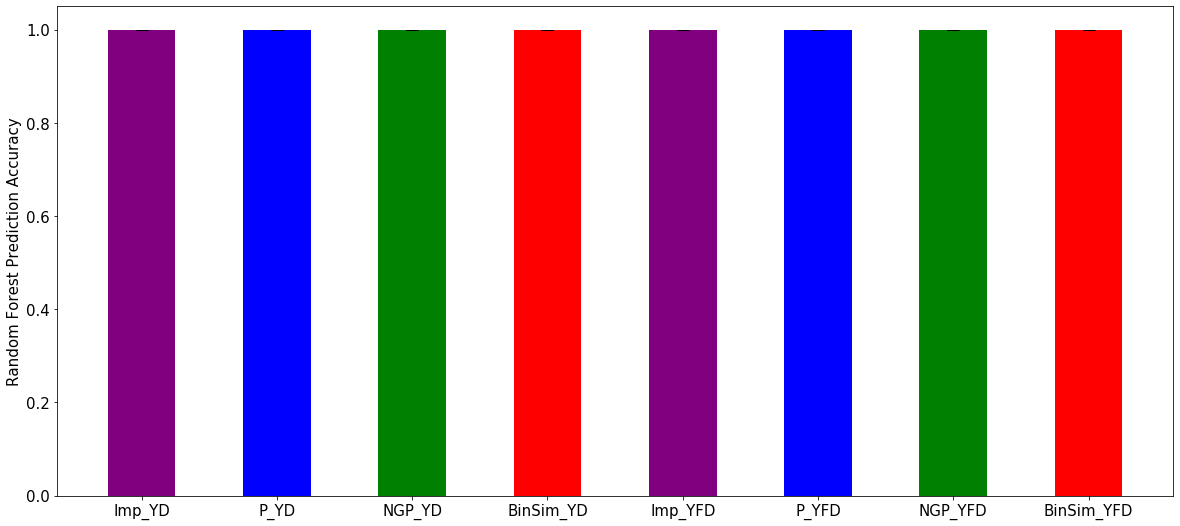

In [83]:
# Plotting bar plots with standard deviation error bars
f, ax = plt.subplots(figsize=(20, 9))
#sns.set_context('talk')
colors = ['purple','blue','green','red','purple','blue','green','red']
#color = sns.color_palette('tab10')
plt.bar(height = Scores_H.T['Accuracy'], x = Scores_H.columns, width = 0.5, color = color, alpha = 1)
ax.errorbar(x = Scores_H.columns, y = Scores_H.T['Accuracy'], yerr = Scores_std_H.iloc[0,:], 
            ls = 'none', ecolor = 'black', capsize = 6)
plt.ylim(0,1.05)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Random Forest Prediction Accuracy', fontsize = 15)
plt.show()

### Characteristics of the features considered as important in the differently-treated datasets (YD and YFD) - MSNorm

We take the 2% most important features in each case and calculate the median number of samples those features appear (samples_m), the median number of different groups/varieties those features appear in (groups_n) and the ratio between these two measures (ratio_m, has a maximum of 3). 

A swarmplot is also built to see the distributions of the number of samples each important feature in each method appears to see their overall distribution.

We also see how many times the importance of the most important feature is greater than the average importance of a feature in each case ('magni') as well as the % of the model explained (that use) the 2% of the most important features ('explained').

In [84]:
# Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature,
# calculating % explained by these features (explained) and identification of important features (in negative and positive GD)
ev = []
magni = []
explained = []
imp_feat_id_YD = {}
imp_feat_id_YFD = {}

for name in Imp_feat:
    # Choose the respective original spectra for each differently treated dataset
    if name.endswith('YD'):
        #continue
        Spectra = Yeast_dfs['intensities']
    elif name.endswith('YFD'):
        #continue
        Spectra = Yeast_form_dfs['intensities']
    
    # Important Features
    imp_features = Imp_feat[name]
    
    ratio = []
    nsamples = []
    n_groups = []
    imp_feat_id_temp = []
    
    # Top 2% (rounded)
    number = round(0.02*len(Spectra))
    magni.append(imp_features[0][1]/(1/len(Spectra))) # Calculate, store how many times feature is more important than average
    
    a = 0 # Count the % explained - add for each feature
    for i in range(number): # Iterate for only the number of features considered as important
        a = a + imp_features[i][1]*100 
        
        ngroups = {}
        line = Spectra.loc[imp_features[i][2],:].notnull() # Identify feature in Spectra
        nsamples.append(line.sum()) # Count how many samples the feature appears in
        
        # Count how many groups the feature appears in
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.cdl.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        
        # Calculate the ratio of number of samples to number of groups the feature appears in
        ratio.append(nsamples[-1]/n_groups[-1])
        
        # Store identification of feature
        imp_feat_id_temp.append(imp_features[i][2])
    
    explained.append(a) # Store % explained
    
    # Organizing info in a dataframe and store it in 'ev'
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)
    
    # Storing important feature identification
    if name.endswith('YD'):
        imp_feat_id_YD[name] = imp_feat_id_temp
    elif name.endswith('YFD'):
        imp_feat_id_YFD[name] = imp_feat_id_temp
    #print(ev[4])

In [85]:
# Calculating medians of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []

# For each DataFrame in 'ev'
for i in range(len(ev)):
    # Calculate and store the median for the sample number, group number and ratio
    samples_m.append(np.median(ev[i].iloc[:,0]))
    groups_m.append(np.median(ev[i].iloc[:,1]))
    ratio_m.append(np.median(ev[i].iloc[:,2]))
    
# Organize information in a DataFrame
df = pd.DataFrame(columns = ['Sample Nº', 'Group nº', 'Ratio'], index = [i  for i in Imp_feat])
df['Sample Nº'] = samples_m
df['Group nº'] = groups_m
df['Ratio'] = ratio_m
#print(df)

# Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"Sample Nº": None, "Group nº": None, 'Ratio':None}, index=[''])
df = pd.concat([df.iloc[:4], line, df.iloc[4:8]])

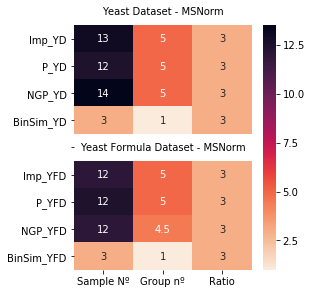

In [86]:
# Plot the results in a Heatmap (adjusting parameters)
f, ax = plt.subplots(figsize=(4, 4.5))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.5,-0.5,'Yeast Dataset - MSNorm',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,4.5,'Yeast Formula Dataset - MSNorm',horizontalalignment='center', verticalalignment='center')
plt.show()

#### Yeast Dataset - MSNorm

Plotting swarmplots with the distributions of samples important features appear in.

Distribution of number of samples important features of Random Forest models appear in - Yeast Dataset (MSNorm)


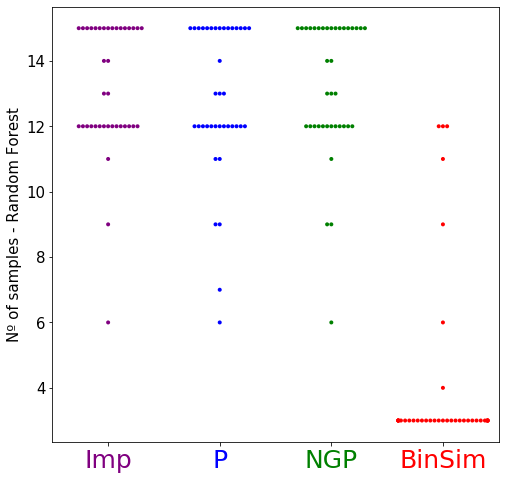

In [87]:
# Plot the swarm plot and adjust parameters
f, ax = plt.subplots(figsize=(8,8))
data = [ev[i]['nsamples'] for i in range(4)] #range(len(ev))]

sns.swarmplot(data=data, size = 4, palette = ['purple','blue','green','red'])
ax.set(xticklabels = ['Imp','P','NGP','BinSim'])
ax.tick_params(axis='x', which='major', labelsize=25)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.ylabel('Nº of samples - Random Forest', fontsize = 15)
colors = ['purple','blue','green','red']
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)

print('Distribution of number of samples important features of Random Forest models appear in - Yeast Dataset (MSNorm)')
plt.show()

#### Yeast Formula Dataset - MSNorm

Distribution of number of samples important features of Random Forest models appear in - Yeast Formula Dataset (MSNorm)


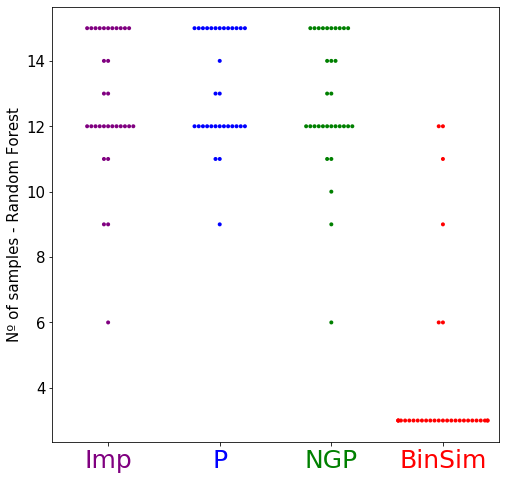

In [88]:
f, ax = plt.subplots(figsize=(8,8))
data = [ev[i]['nsamples'] for i in range(4,8)] #range(len(ev))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data, size = 4, palette = ['purple','blue','green','red'])
ax.set(xticklabels = ['Imp','P','NGP','BinSim'])
ax.tick_params(axis='x', which='major', labelsize=25)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.ylabel('Nº of samples - Random Forest', fontsize = 15)
colors = ['purple','blue','green','red']
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)

print('Distribution of number of samples important features of Random Forest models appear in - Yeast Formula Dataset (MSNorm)')
#plt.savefig('RF-YFD-IF')
plt.show()

In [89]:
print('Magnitude of most important feature:', )
for i in range(len(Imp_feat.keys())):
    print(list(Imp_feat.keys())[i], '   \t', magni[i])
    
print('\n')
print('% of model explained by the 2% most important features')
for i in range(len(Imp_feat.keys())):
    print(list(Imp_feat.keys())[i], '    \t', explained[i])

Magnitude of most important feature:
Imp_YD    	 4.109281351490883
P_YD    	 4.050573053017911
NGP_YD    	 4.080326878969576
BinSim_YD    	 4.821380942212778
Imp_YFD    	 3.831424285360896
P_YFD    	 3.9971084260922067
NGP_YFD    	 4.065429611010831
BinSim_YFD    	 4.837900586587494


% of model explained by the 2% most important features
Imp_YD     	 6.491185168444057
P_YD     	 6.481435577592304
NGP_YD     	 6.4453116121280765
BinSim_YD     	 7.90381381913799
Imp_YFD     	 6.654663342534775
P_YFD     	 6.658703530736142
NGP_YFD     	 6.621503183497157
BinSim_YFD     	 8.126369904840113


#### Intersections of Important Features used to build each differently-treated dataset - Random Forest

#### Yeast Dataset - MSNorm

Be careful with features present in all sets, in 3 of the sets and in 2 sets for calculating values for Venn Diagram

Easier ways to obtain the results directly are available but since it is already done.

In [90]:
# Easier to write
name = imp_feat_id_YD

# How many Features are in at least one of the sets of important features of the differently-treated dataset
union = len(np.union1d(np.union1d(np.union1d(name['Imp_YD'],name['P_YD']), name['NGP_YD']), name['BinSim_YD']))
print('Nº of different features across the sets of important features:', union)

# How many Features are in all sets of important features of the differently-treated dataset
intersection = len(np.intersect1d(np.intersect1d(np.intersect1d(name['Imp_YD'],name['P_YD']), name['NGP_YD']),
                                  name['BinSim_YD']))
print('Nº of features present in all sets of important features:', intersection, '\n')

# Build DataFrame for pairwise intersection of the sets of important features
intersec = pd.DataFrame(np.zeros((4,4)), index=name.keys(), columns=name.keys())
for i in name.keys():
    for j in name.keys():
        intersec.loc[i,j] = len(np.intersect1d(name[i],name[j]))#/len(name[i])     
        
# Intersections of 3 of the 4 different sets of important features
for i,j,m in itertools.combinations(name,3):
    print('Sets of features considered:',i,',',j,',',m,'.',
          'Number of features in the 3 sets:', len(np.intersect1d(np.intersect1d(name[i],name[j]), name[m])))

print('\nDataframe with the intersection of two set of important features for each pairwise combination:')    
print(intersec)

Nº of different features across the sets of important features: 88
Nº of features present in all sets of important features: 1 

Sets of features considered: Imp_YD , P_YD , NGP_YD . Number of features in the 3 sets: 25
Sets of features considered: Imp_YD , P_YD , BinSim_YD . Number of features in the 3 sets: 2
Sets of features considered: Imp_YD , NGP_YD , BinSim_YD . Number of features in the 3 sets: 1
Sets of features considered: P_YD , NGP_YD , BinSim_YD . Number of features in the 3 sets: 1

Dataframe with the intersection of two set of important features for each pairwise combination:
           Imp_YD  P_YD  NGP_YD  BinSim_YD
Imp_YD       38.0  29.0    27.0        3.0
P_YD         29.0  38.0    29.0        3.0
NGP_YD       27.0  29.0    38.0        1.0
BinSim_YD     3.0   3.0     1.0       38.0


#### Yeast Formula Dataset - MSNorm

Be careful with features present in all sets, in 3 of the sets and in 2 sets for calculating values for Venn Diagram.

Easier ways to obtain the results directly are available but since it is already done.

In [91]:
# Easier to write
name = imp_feat_id_YFD

# How many Features are in at least one of the sets of important features of the differently-treated dataset
union = len(np.union1d(np.union1d(np.union1d(name['Imp_YFD'],name['P_YFD']), name['NGP_YFD']), name['BinSim_YFD']))
print('Nº of different features across the sets of important features:', union)

# How many Features are in all sets of important features of the differently-treated dataset
intersection = len(np.intersect1d(np.intersect1d(np.intersect1d(name['Imp_YFD'],name['P_YFD']), name['NGP_YFD']),
                                  name['BinSim_YFD']))
print('Nº of features present in all sets of important features:', intersection, '\n')

# Build DataFrame for pairwise intersection of the sets of important features
intersec = pd.DataFrame(np.zeros((4,4)), index=name.keys(), columns=name.keys())
for i in name.keys():
    for j in name.keys():
        intersec.loc[i,j] = len(np.intersect1d(name[i],name[j]))#/len(name[i])     
        
# Intersections of 3 of the 4 different sets of important features
for i,j,m in itertools.combinations(name,3):
    print('Sets of features considered:',i,',',j,',',m,'.',
          'Number of features in the 3 sets:', len(np.intersect1d(np.intersect1d(name[i],name[j]), name[m])))

print('\nDataframe with the intersection of two set of important features for each pairwise combination:')    
print(intersec)

Nº of different features across the sets of important features: 78
Nº of features present in all sets of important features: 0 

Sets of features considered: Imp_YFD , P_YFD , NGP_YFD . Number of features in the 3 sets: 20
Sets of features considered: Imp_YFD , P_YFD , BinSim_YFD . Number of features in the 3 sets: 0
Sets of features considered: Imp_YFD , NGP_YFD , BinSim_YFD . Number of features in the 3 sets: 1
Sets of features considered: P_YFD , NGP_YFD , BinSim_YFD . Number of features in the 3 sets: 0

Dataframe with the intersection of two set of important features for each pairwise combination:
            Imp_YFD  P_YFD  NGP_YFD  BinSim_YFD
Imp_YFD        32.0   20.0     26.0         1.0
P_YFD          20.0   32.0     21.0         2.0
NGP_YFD        26.0   21.0     32.0         1.0
BinSim_YFD      1.0    2.0      1.0        32.0


## PLS-DA - Classifiers

Creating the target vectors matrix where each different group is made into a column and 1 represents the sample belongs to that group (0 means it doesn't belong) with one-hot encoding.

PLS-DA models were built using the PLSRegression module of scikit-learn while imposing a decision rule where the group corresponding to the maximum value in the predicted regression vector (one value for each group) obtained for a test sample (ypred) is chosen. 

In [92]:
matrix = pd.get_dummies(all_labels)
matrix

,BY4741,dENO1,dGLO1,dGLO2,dGRE3
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,1
4,0,0,0,0,1
5,0,0,0,0,1
6,0,1,0,0,0
7,0,1,0,0,0
8,0,1,0,0,0
9,0,0,1,0,0


### Optimization - Search for the best number of components to use

The number of components were optimized by observing the score metric of the PLSRegression of scikit learn, that is, the 1 - PRESS/SS or Q2 of models built with 1 to n components.

PRESS - Predictive Residual Sum of Squares
SS - residual Sum of Squares

Strategy: Perform PLS-DA with different number of components and observe the score (given directly by the method score, inverse relation to the mean-squared error (MSE)) of the models built estimated with stratified 3-fold cross-validation. Then plot the different results obtained and see at which point (number of components) the score starts approaching a "stable maximum value".

To observe details of the `optim_PLS` function - performs PLS analysis and obtains the results stated above with number of components defined from 1 to max_comp - see multianalysis.py file. 

These regression metrics are not suitable to evaluate the performance of the classifier, they were just used to optimize the number of components to build the final PLS-DA models.

In [93]:
%%capture --no-stdout
# Store Results
PLS_optim = {}

# Build and extract metrics from models build with different number of components by using the optim_PLS function.
for name, data in datasets.items():
    print(f'Optimizing PLS-DA for {name} ...', end='')
    CVs, CVr2s, MSEs = ma.optim_PLS(data, max_comp = 30)
    PLS_optim[name] = CVs
    print(f'done')    

Optimizing PLS-DA for Imp_YD ...done
Optimizing PLS-DA for P_YD ...done
Optimizing PLS-DA for NGP_YD ...done
Optimizing PLS-DA for BinSim_YD ...done
Optimizing PLS-DA for Imp_YFD ...done
Optimizing PLS-DA for P_YFD ...done
Optimizing PLS-DA for NGP_YFD ...done
Optimizing PLS-DA for BinSim_YFD ...done


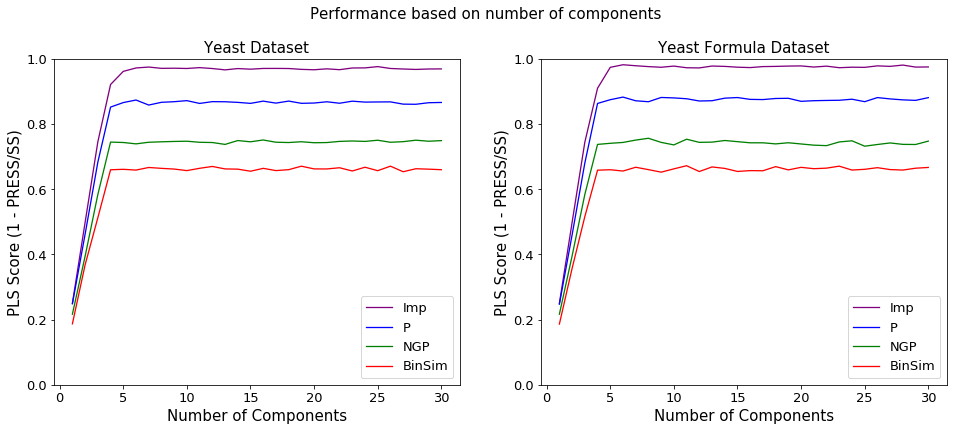

In [94]:
# Plotting the results and adjusting plot parameters
f, axes = plt.subplots(1, 2, figsize = (16,6))
quadrant = [axes[0], axes[1]]
plt.suptitle('Performance based on number of components', fontsize = 15, x = 0.5, y = 1)
colors = ['purple','blue','green','red','purple','blue','green','red']
i=0

for name, data in PLS_optim.items():
    if name.endswith('YD'):
        # YD
        quadrant[0].plot(range(1,31),data, color=colors[i])
        quadrant[0].set_xlabel('Number of Components', fontsize=15)
        quadrant[0].set_ylabel('PLS Score (1 - PRESS/SS)', fontsize=15)
        quadrant[0].set_title('Yeast Dataset', fontsize=15)
        quadrant[0].tick_params(axis='both', which='major', labelsize=13)
        quadrant[0].legend(('Imp', 'P', 'NGP', 'BinSim'), fontsize=13)
        quadrant[0].set_ylim([0, 1])
        
    if name.endswith('YFD'):
        # YFD
        quadrant[1].plot(range(1,31),data, color=colors[i])
        quadrant[1].set_xlabel('Number of Components', fontsize=15)
        quadrant[1].set_ylabel('PLS Score (1 - PRESS/SS)', fontsize=15)
        quadrant[1].set_title('Yeast Formula Dataset', fontsize=15)
        quadrant[1].tick_params(axis='both', which='major', labelsize=13)
        quadrant[1].legend(('Imp', 'P', 'NGP', 'BinSim'), fontsize=13)
        quadrant[1].set_ylim([0, 1])
    
    i = i+1

4 components were used for the PLS-DA model made after (for both YD and YFD).

### Application of PLS-DA

We can now transform the PLS algorithm (PLS2 algorithm used) to give classification of samples instead of regression using a decision rule to interpret the y_pred result given for each test sample and decide what group it belongs to. In this case a simple rule of the group with the highest number (closer to 1) is decided to be the group to which said sample belongs to - naive MAX rule. Models were evaluated according to their predictive accuracy estimated by 3-fold cross-validation.

Use of function `model_PLSDA` of multianalysis.py file. See this file to see the application of this function more in-depth (used `PLSRegression` from scikit-learn).

3 different feature importance metrics (feat_type):

- VIP (Variable Importance/Influence in Projection) - used in dissertation (slowest)
- Coef. (regression coefficients - sum)
- Weights (Sum of the X-weights for each feature)

In [95]:
# Dictionaries to store results
PLS_accu = {}
PLS_score = {}
PLS_feat = {}

In [96]:
%%capture --no-stdout
# For each differently-treated dataset, fit PLS-DA models on 200 randomly sampled folds (for stratified 3-fold cross validation)
# Store results in dictionaries (results for 200 iterations).
for name, data in datasets.items():
    print(f'Fitting PLS-DA for {name} ...', end='')
    accu, score, u, imp_features = ma.model_PLSDA(data, n_comp = 4, iter_num = 200, feat_type = 'VIP')
    PLS_accu[name] = accu
    PLS_score[name] = score
    PLS_feat[name] = imp_features
    print(f'done')  

Fitting PLS-DA for Imp_YD ...done
Fitting PLS-DA for P_YD ...done
Fitting PLS-DA for NGP_YD ...done
Fitting PLS-DA for BinSim_YD ...done
Fitting PLS-DA for Imp_YFD ...done
Fitting PLS-DA for P_YFD ...done
Fitting PLS-DA for NGP_YFD ...done
Fitting PLS-DA for BinSim_YFD ...done


#### Results of the PLS-DA - Performance (Predictive Accuracy) 

#### Yeast Dataset - MSNorm

Predictive Accuracy of PLS-DA models - Yeast Dataset (MSNorm)


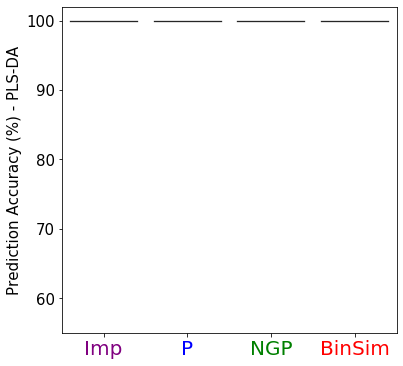

In [97]:
# Plot the distribution of prediction accuracy of the 200 iterations of models built from the differently-treated datasets
# Adjust Parameters
f, ax = plt.subplots(figsize=(6,6))
colors = ['purple','blue','green','red']
data=pd.DataFrame.from_dict(PLS_accu).iloc[:,:4] * 100
data.columns = ['Imp', 'P', 'NGP', 'BinSim']
sns.violinplot(data=data, palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy (%) - PLS-DA', fontsize = 15)
plt.ylim([55,102])
ax.tick_params(axis='x', which='major', labelsize= 20)
ax.tick_params(axis='y', which='major', labelsize= 15)

for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)

print('Predictive Accuracy of PLS-DA models - Yeast Dataset (MSNorm)')
plt.show()

#### Yeast Formula Dataset - MSNorm

Predictive Accuracy of PLS-DA models - Yeast Formula Dataset


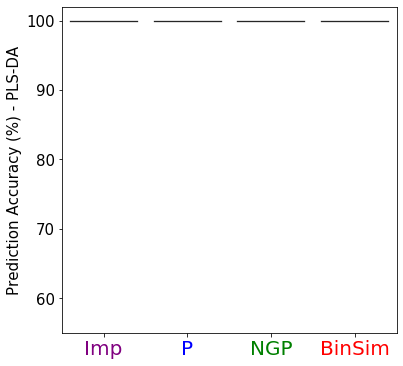

In [98]:
# Plot the distribution of prediction accuracy of the 200 iterations of models built from the differently-treated datasets
# Adjust Parameters
f, ax = plt.subplots(figsize=(6,6))
colors = ['purple','blue','green','red']
data=pd.DataFrame.from_dict(PLS_accu).iloc[:,:4] * 100
data.columns = ['Imp', 'P', 'NGP', 'BinSim']
sns.violinplot(data=data, palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy (%) - PLS-DA', fontsize = 15)
plt.ylim([55,102])
ax.tick_params(axis='x', which='major', labelsize= 20)
ax.tick_params(axis='y', which='major', labelsize= 15)

for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)

print('Predictive Accuracy of PLS-DA models - Yeast Formula Dataset')
plt.show()

#### Accuracies Summary

In [99]:
# Average Accuracy across the iterations for each differently-treated dataset
Accuracy = {}
Accuracy_std = {}
for name in PLS_score.keys():
    Accuracy[name] = np.mean(PLS_accu[name])
    Accuracy_std[name] = np.std(PLS_accu[name])

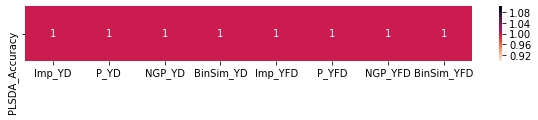

In [100]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys()).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Accuracy_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Accuracy'])

In [101]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys(), columns  = ['Accuracy']).T
Accuracy_H.loc['SD'] = list(Accuracy_std.values())
Accuracy_H.T

,Accuracy,SD
Imp_YD,1.0,0.0
P_YD,1.0,0.0
NGP_YD,1.0,0.0
BinSim_YD,1.0,0.0
Imp_YFD,1.0,0.0
P_YFD,1.0,0.0
NGP_YFD,1.0,0.0
BinSim_YFD,1.0,0.0


### Characteristics of the features considered as important in the differently-treated datasets (YD and YFD) - MSNorm

Same process as applied for Random Forest.

In [102]:
# Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature
# and identification of important features (in negative and positive GD)
ev_PLS = []
magni_PLS = []
imp_feat_id_PLS_YD = {}
imp_feat_id_PLS_YFD = {}

for name in PLS_feat:
    # Choose the respective original spectra for each differently treated dataset
    if name.endswith('YD'):
        #continue
        Spectra = Yeast_dfs['intensities']
    elif name.endswith('YFD'):
        #continue
        Spectra = Yeast_form_dfs['intensities']
    
    # Important Features
    imp_features = PLS_feat[name]
    
    ratio = []
    nsamples = []
    n_groups = []
    imp_feat_id_temp = []
    
    # Top 2% (rounded)
    number = round(0.02*len(Spectra))
    magni_PLS.append(imp_features[0][1]/(1/len(Spectra))) # Calculate how many times feature is more important than average
    
    for i in range(number): # Iterate for only the number of features considered as important

        ngroups = {}
        line = Spectra.loc[imp_features[i][2],:].notnull() # Identify feature in Spectra
        nsamples.append(line.sum()) # Count how many samples the feature appears in
        
        # Count how many groups the feature appears in
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.cdl.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        
        # Calculate the ratio of number of samples to number of groups the feature appears in
        ratio.append(nsamples[-1]/n_groups[-1])
        
        # Store identification of feature
        imp_feat_id_temp.append(imp_features[i][2])
    
    # Organizing info in a dataframe and store it in 'ev_PLS'
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev_PLS.append(df)
    
    # Storing important feature identification
    if name.endswith('YD'):
        imp_feat_id_PLS_YD[name] = imp_feat_id_temp
    elif name.endswith('YFD'):
        imp_feat_id_PLS_YFD[name] = imp_feat_id_temp
    #print(ev[4])

In [103]:
# Calculating medians of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []

# For each DataFrame in 'ev_PLS'
for i in range(len(ev_PLS)):
    # Calculate and store the median for the sample number, group number and ratio
    samples_m.append(np.median(ev_PLS[i].iloc[:,0]))
    groups_m.append(np.median(ev_PLS[i].iloc[:,1]))
    ratio_m.append(np.median(ev_PLS[i].iloc[:,2]))
    
# Organize information in a DataFrame
df = pd.DataFrame(columns = ['Sample Nº', 'Group nº', 'Ratio'], index = [i  for i in PLS_feat])
df['Sample Nº'] = samples_m
df['Group nº'] = groups_m
df['Ratio'] = ratio_m
#print(df)

# Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"Sample Nº": None, "Group nº": None, 'Ratio':None}, index=[''])
df = pd.concat([df.iloc[:4], line, df.iloc[4:8]])

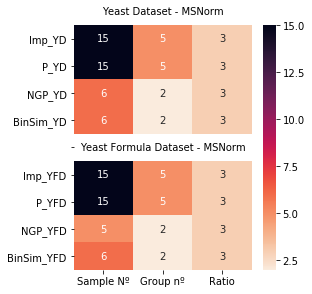

In [104]:
f, ax = plt.subplots(figsize=(4, 4.5))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
#plt.suptitle('PLS Imp. Feat.', fontsize = 15, x = 0.43, y = 1)
plt.text(1.5,-0.5,'Yeast Dataset - MSNorm',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,4.5,'Yeast Formula Dataset - MSNorm',horizontalalignment='center', verticalalignment='center')
plt.show()

Distribution of number of samples important features of PLS-DA models appear in - Yeast Dataset


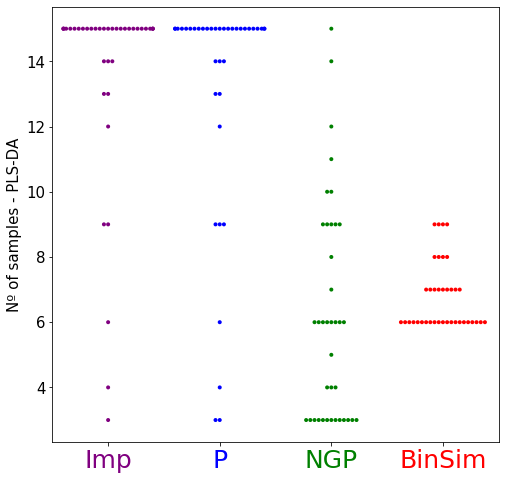

In [105]:
# Plot the swarm plot and adjust parameters
f, ax = plt.subplots(figsize=(8,8))
data = [ev_PLS[i]['nsamples'] for i in range(4)] #range(len(ev))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data, size = 4, palette = ['purple','blue','green','red']*2)
ax.set(xticklabels = ['Imp','P','NGP','BinSim'])
ax.tick_params(axis='x', which='major', labelsize=25)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.ylabel('Nº of samples - PLS-DA', fontsize = 15)
colors = ['purple','blue','green','red']
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)

print('Distribution of number of samples important features of PLS-DA models appear in - Yeast Dataset')
plt.show()

Distribution of number of samples important features of PLS-DA models appear in - Yeast Formula Dataset


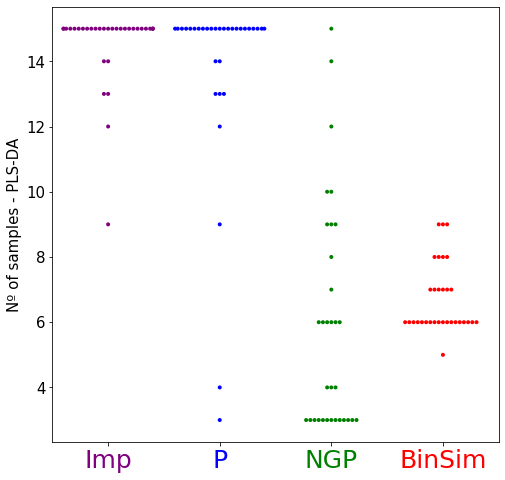

In [106]:
# Plot the swarm plot and adjust parameters
f, ax = plt.subplots(figsize=(8,8))
data = [ev_PLS[i]['nsamples'] for i in range(4,8)] # range(len(ev))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data, size = 4, palette = ['purple','blue','green','red']*2)
ax.set(xticklabels = ['Imp','P','NGP','BinSim'])
ax.tick_params(axis='x', which='major', labelsize=25)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.ylabel('Nº of samples - PLS-DA', fontsize = 15)
colors = ['purple','blue','green','red']
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)

print('Distribution of number of samples important features of PLS-DA models appear in - Yeast Formula Dataset')
plt.show()

In [107]:
print('Magnitude of most important features for each case:')
for i in range(len(PLS_feat.keys())):
    print(list(PLS_feat.keys())[i], '   \t', magni_PLS[i])

Magnitude of most important features for each case:
Imp_YD    	 39860.39823006095
P_YD    	 19903.674773867875
NGP_YD    	 4195.610592315953
BinSim_YD    	 3653.060642374056
Imp_YFD    	 30381.264251427456
P_YFD    	 15904.336638319191
NGP_YFD    	 3450.061879951624
BinSim_YFD    	 3075.095098971808


#### Intersections of Important Features used to build each differently-treated dataset - PLS-DA

#### Yeast Dataset - MSNorm

Be careful with features present in all sets, in 3 of the sets and in 2 sets for calculating values for Venn Diagram

Easier ways to obtain the results directly are available but since it is already done.

In [108]:
# Easier to write
name = imp_feat_id_PLS_YD

# How many Features are in at least one of the sets of important features of the differently-treated dataset
union = len(np.union1d(np.union1d(np.union1d(name['Imp_YD'],name['P_YD']), name['NGP_YD']), name['BinSim_YD']))
print('Nº of different features across the sets of important features:', union)

# How many Features are in all sets of important features of the differently-treated dataset
intersection = len(np.intersect1d(np.intersect1d(np.intersect1d(name['Imp_YD'],name['P_YD']), name['NGP_YD']),
                                  name['BinSim_YD']))
print('Nº of features present in all sets of important features:', intersection, '\n')

# Build DataFrame for pairwise intersection of the sets of important features
intersec = pd.DataFrame(np.zeros((4,4)), index=name.keys(), columns=name.keys())
for i in name.keys():
    for j in name.keys():
        intersec.loc[i,j] = len(np.intersect1d(name[i],name[j]))#/len(name[i])     
        
# Intersections of 3 of the 4 different sets of important features
for i,j,m in itertools.combinations(name,3):
    print('Sets of features considered:',i,',',j,',',m,'.',
          'Number of features in the 3 sets:', len(np.intersect1d(np.intersect1d(name[i],name[j]), name[m])))

print('\nDataframe with the intersection of two set of important features for each pairwise combination:')    
print(intersec)

Nº of different features across the sets of important features: 99
Nº of features present in all sets of important features: 1 

Sets of features considered: Imp_YD , P_YD , NGP_YD . Number of features in the 3 sets: 8
Sets of features considered: Imp_YD , P_YD , BinSim_YD . Number of features in the 3 sets: 1
Sets of features considered: Imp_YD , NGP_YD , BinSim_YD . Number of features in the 3 sets: 1
Sets of features considered: P_YD , NGP_YD , BinSim_YD . Number of features in the 3 sets: 1

Dataframe with the intersection of two set of important features for each pairwise combination:
           Imp_YD  P_YD  NGP_YD  BinSim_YD
Imp_YD       38.0  36.0     8.0        1.0
P_YD         36.0  38.0    10.0        1.0
NGP_YD        8.0  10.0    38.0        7.0
BinSim_YD     1.0   1.0     7.0       38.0


#### Yeast Formula Dataset - MSNorm

Be careful with features present in all sets, in 3 of the sets and in 2 sets for calculating values for Venn Diagram.

Easier ways to obtain the results directly are available but since it is already done.

In [109]:
# Easier to write
name = imp_feat_id_PLS_YFD

# How many Features are in at least one of the sets of important features of the differently-treated dataset
union = len(np.union1d(np.union1d(np.union1d(name['Imp_YFD'],name['P_YFD']), name['NGP_YFD']), name['BinSim_YFD']))
print('Nº of different features across the sets of important features:', union)

# How many Features are in all sets of important features of the differently-treated dataset
intersection = len(np.intersect1d(np.intersect1d(np.intersect1d(name['Imp_YFD'],name['P_YFD']), name['NGP_YFD']),
                                  name['BinSim_YFD']))
print('Nº of features present in all sets of important features:', intersection, '\n')

# Build DataFrame for pairwise intersection of the sets of important features
intersec = pd.DataFrame(np.zeros((4,4)), index=name.keys(), columns=name.keys())
for i in name.keys():
    for j in name.keys():
        intersec.loc[i,j] = len(np.intersect1d(name[i],name[j]))#/len(name[i])     
        
# Intersections of 3 of the 4 different sets of important features
for i,j,m in itertools.combinations(name,3):
    print('Sets of features considered:',i,',',j,',',m,'.',
          'Number of features in the 3 sets:', len(np.intersect1d(np.intersect1d(name[i],name[j]), name[m])))

print('\nDataframe with the intersection of two set of important features for each pairwise combination:')    
print(intersec)

Nº of different features across the sets of important features: 87
Nº of features present in all sets of important features: 1 

Sets of features considered: Imp_YFD , P_YFD , NGP_YFD . Number of features in the 3 sets: 4
Sets of features considered: Imp_YFD , P_YFD , BinSim_YFD . Number of features in the 3 sets: 1
Sets of features considered: Imp_YFD , NGP_YFD , BinSim_YFD . Number of features in the 3 sets: 1
Sets of features considered: P_YFD , NGP_YFD , BinSim_YFD . Number of features in the 3 sets: 1

Dataframe with the intersection of two set of important features for each pairwise combination:
            Imp_YFD  P_YFD  NGP_YFD  BinSim_YFD
Imp_YFD        32.0   28.0      4.0         1.0
P_YFD          28.0   32.0      6.0         1.0
NGP_YFD         4.0    6.0     32.0         7.0
BinSim_YFD      1.0    1.0      7.0        32.0


### Example of models built with the full dataset and sample representation on the two most important Components/Latent Variables

In [110]:
def plot_PLSDA(principaldf, label_colors, components=(1,2), title="PLS-DA", ax=None):
    "Plot the projection of samples in the 2 main components of a PLS-DA model."
    
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    col_c1_name, col_c2_name = principaldf.columns[[loc_c1, loc_c2]]
    
    with sns.axes_style("whitegrid"):
        #ax.axis('equal')
        ax.set_xlabel(f'{col_c1_name}', fontsize = 15)
        ax.set_ylabel(f'{col_c2_name}', fontsize = 15)

        unique_labels = principaldf['Label'].unique()

        for lbl in unique_labels:
            subset = principaldf[principaldf['Label']==lbl]
            ax.scatter(subset[col_c1_name],
                       subset[col_c2_name],
                       s=50, color=label_colors[lbl], label=lbl)

        ax.legend(framealpha=1)
        ax.set_title(title, fontsize=15)

#### NGP treated YD - MSNorm

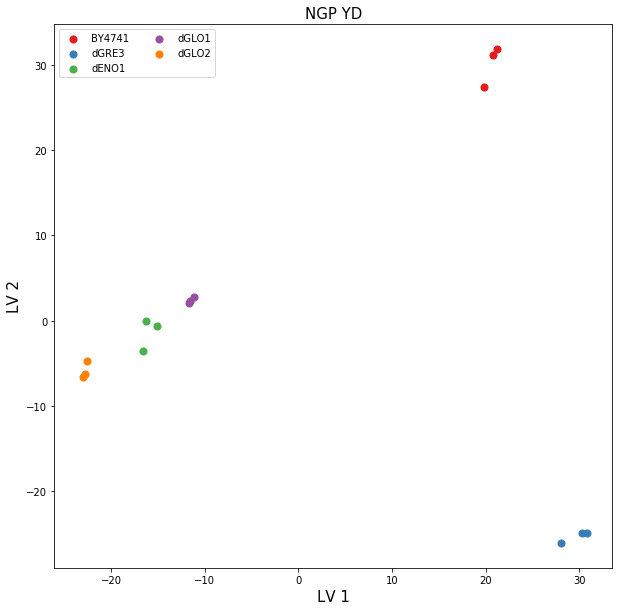

In [111]:
n_components = 4

plsreg_GPneg = ma.PLSscores_with_labels(NGP_YD, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="NGP YD", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

#### BinSim treated YD - MSNorm

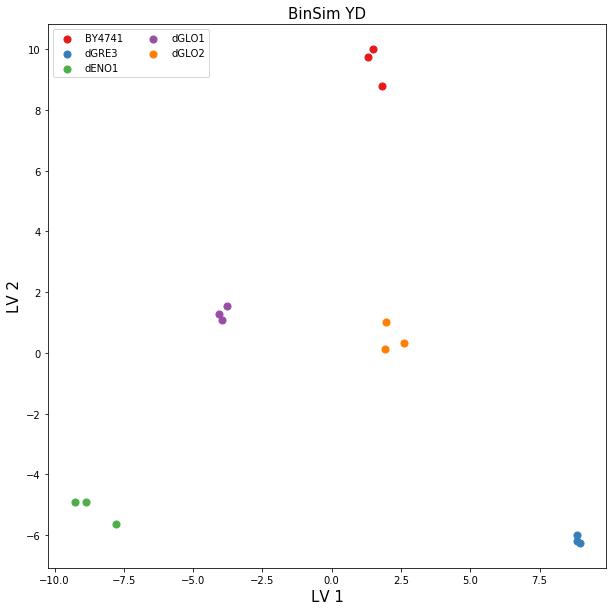

In [112]:
n_components = 4

plsreg_GPneg = ma.PLSscores_with_labels(bin_YD, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="BinSim YD", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

## Permutation Tests

Permutation tests is based on shuffling the labels of the different samples, shuflling the groups where they belong with the intent to see if the classifier tested, whether it is Random Forest or PLS-DA found a significant class structure in the data - assess the significance of the predictive accuracy results. 

For that a random 3-fold cross-validation is performed on the original dataset (to serve as a comparation point) and 1000 permutations of datasets with labels randomly shuffled around with the model being evaluated by how good the predictions the model does of the test data is. 

The empirical p-value is given by (the number of times the permutation accuracy was bigger than the random 3-fold cross-validation made with the original dataset + 1) / (number of permutations + 1) (source: Ojala2010 - error should be the opposite of the accuracy).

Histograms with the prediction accuracy of the different permutations were plotted and compared to the accuracy got with the original dataset.

### Permutation Tests - Random Forests (very slow)

Use of `permutation_RF` function from multianalysis.py. See details about the application of this function in the multianalysis.py file.

In [113]:
# Store results
CV = {}
PMs = {}
pvalue = {}

all_data = (Imp_YD, P_YD, NGP_YD, bin_YD, Imp_YFD, P_YFD, NGP_YFD, bin_YFD)
names = ('Imp Treatment','P Treatment','NGP Treatment','BinSim Treatment',
        'Imp Treatment_YFD','P Treatment_YFD','NGP Treatment_YFD','BinSim Treatment_YFD')

# Application of permutations tests
for name, data in zip(names, all_data):
    print(f'Permutation test (Random Forest) for {name} ...')
    permuta = ma.permutation_RF(data, iter_num=150, n_fold=3)
    CV[name] = permuta[0]
    PMs[name] = permuta[1]
    pvalue[name] = permuta[2]
    print('Done!')

Permutation test (Random Forest) for Imp Treatment ...
Done!
Permutation test (Random Forest) for P Treatment ...
Done!
Permutation test (Random Forest) for NGP Treatment ...
Done!
Permutation test (Random Forest) for BinSim Treatment ...
Done!
Permutation test (Random Forest) for Imp Treatment_YFD ...
Done!
Permutation test (Random Forest) for P Treatment_YFD ...
Done!
Permutation test (Random Forest) for NGP Treatment_YFD ...
Done!
Permutation test (Random Forest) for BinSim Treatment_YFD ...
Done!


Permutation Test - Yeast Dataset (MSNorm) - Random Forest


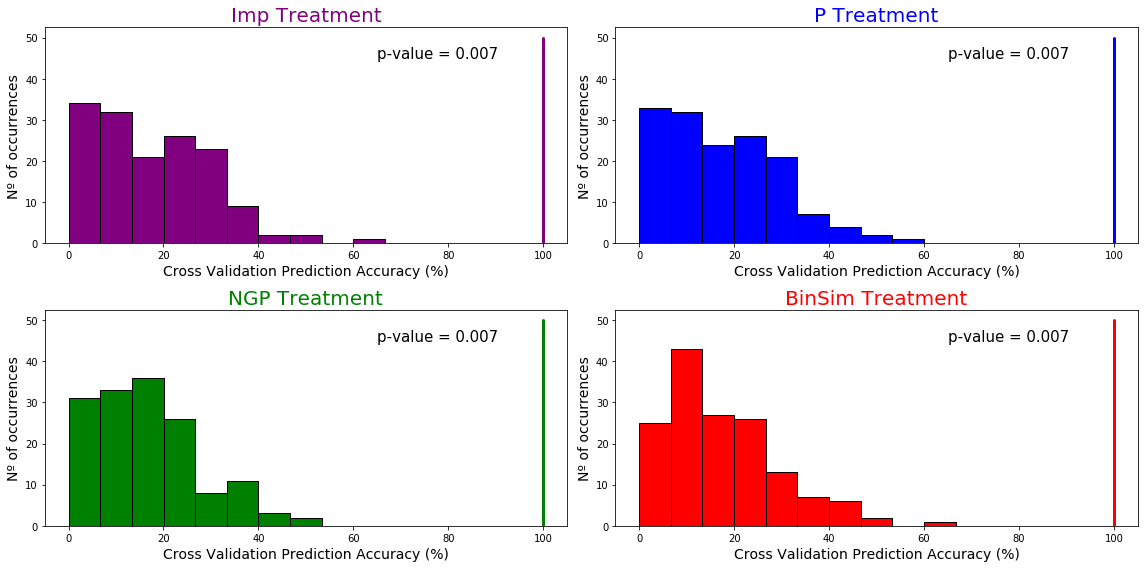

In [114]:
print('Permutation Test - Yeast Dataset (MSNorm) - Random Forest')
# Plot the Permutations test results - Histogram of predictive accuracies of permutated labels and comparison to reference
# predictive accuracy.
f, axes = plt.subplots(2, 2, figsize = (16,8))

#Names = ['Imp_YD', 'P_YD', 'NGP_YD', 'BinSim_YFD']
colors = ['purple', 'blue', 'green', 'red']
Names = ['Imp Treatment','P Treatment','NGP Treatment','BinSim Treatment']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_YD.cdl.labels)

# Setting the parameters of the figure
for q, name, color in zip(quadrant, Names, colors):
    q.hist(np.array(PMs[name])*100, n_labels, range=(0, 100.01), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]* 100], ylim, '-', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name], solid_capstyle='round')
    #q.set(xlabel='Cross Validation Prediction Accuracy (%)', ylabel='Nº of occurrences', fontsize=12)
    q.set_xlabel('Cross Validation Prediction Accuracy (%)', fontsize=14)
    q.set_ylabel('Nº of occurrences', fontsize=14)
    q.text(65,45, 'p-value = %.3f' % pvalue[name], fontsize = 15)
    q.set_title(name, size = 20, color = color)

plt.tight_layout()

Permutation Test - Yeast Formula Dataset (MSNorm) - Random Forest


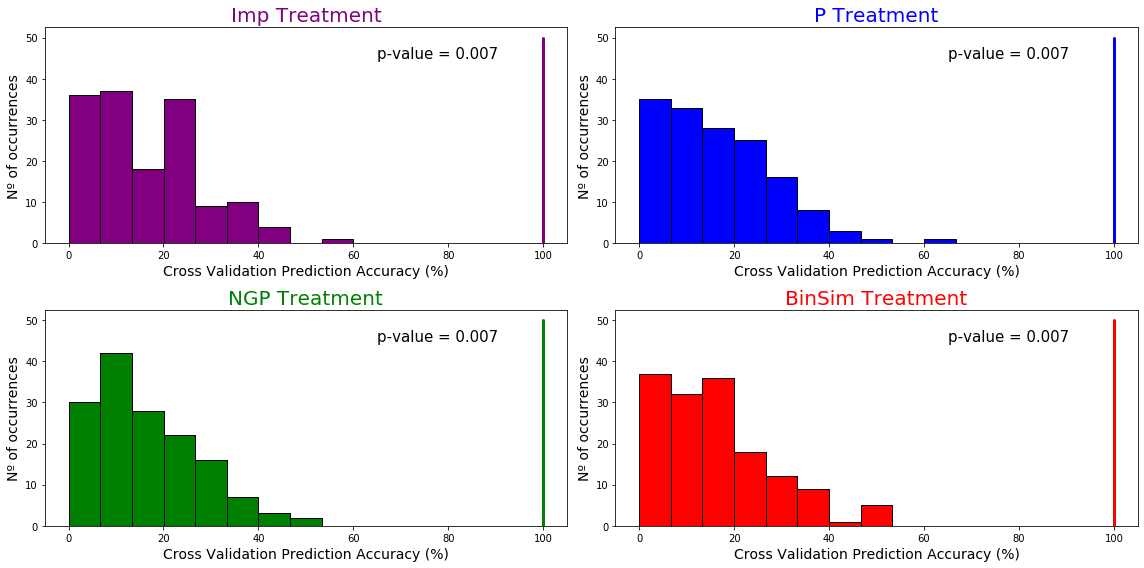

In [115]:
print('Permutation Test - Yeast Formula Dataset (MSNorm) - Random Forest')
# Plot the Permutations test results - Histogram of predictive accuracies of permutated labels and comparison to reference
# predictive accuracy.
f, axes = plt.subplots(2, 2, figsize = (16,8))

colors = ['purple', 'blue', 'green', 'red']
Names = ['Imp Treatment_YFD','P Treatment_YFD','NGP Treatment_YFD','BinSim Treatment_YFD']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_YFD.cdl.labels)

# Setting the parameters of the figure
for q, name, color in zip(quadrant, Names, colors):
    q.hist(np.array(PMs[name])*100, n_labels, range=(0, 100.01), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]* 100], ylim, '-', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name], solid_capstyle='round')
    #q.set(xlabel='Cross Validation Prediction Accuracy (%)', ylabel='Nº of occurrences', fontsize=12)
    q.set_xlabel('Cross Validation Prediction Accuracy (%)', fontsize=14)
    q.set_ylabel('Nº of occurrences', fontsize=14)
    q.text(65,45, 'p-value = %.3f' % pvalue[name], fontsize = 15)
    name = name.split('_')[0]
    q.set_title(name, size = 20, color = color)

plt.tight_layout()

### Permutation Tests - PLS-DA

Same explanation as presented for Permutation Tests - Random Forests

In [116]:
# Store Results
CV_PLS = {}
PMs_PLS = {}
pvalue_PLS = {}

all_data = (Imp_YD, P_YD, NGP_YD, bin_YD, Imp_YFD, P_YFD, NGP_YFD, bin_YFD)
names = ('Imp Treatment','P Treatment','NGP Treatment','BinSim Treatment',
        'Imp Treatment_YFD','P Treatment_YFD','NGP Treatment_YFD','BinSim Treatment_YFD')

# Application of permutations tests
for name, data in zip(names, all_data):
    print(f'permutation test (PLS-DA) for {name} ...')
    permuta = ma.permutation_PLSDA(data, n_comp=4, iter_num=150)
    CV_PLS[name] = permuta[0]
    PMs_PLS[name] = permuta[1]
    pvalue_PLS[name] = permuta[2]
    print('Done!')

permutation test (PLS-DA) for Imp Treatment ...
Done!
permutation test (PLS-DA) for P Treatment ...
Done!
permutation test (PLS-DA) for NGP Treatment ...
Done!
permutation test (PLS-DA) for BinSim Treatment ...


C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for Imp Treatment_YFD ...
Done!
permutation test (PLS-DA) for P Treatment_YFD ...
Done!
permutation test (PLS-DA) for NGP Treatment_YFD ...
Done!
permutation test (PLS-DA) for BinSim Treatment_YFD ...
Done!


Permutation Test - Yeast Dataset (MSNorm) - PLS-DA


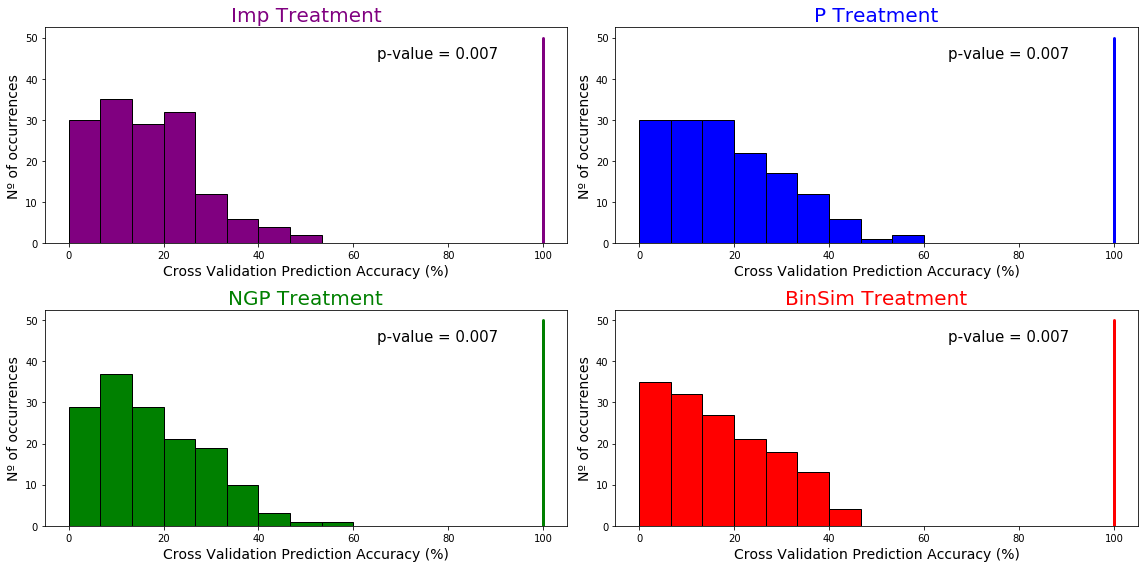

In [117]:
print('Permutation Test - Yeast Dataset (MSNorm) - PLS-DA')
# Plot the Permutations test results - Histogram of predictive accuracies of permutated labels and comparison to reference
# predictive accuracy.
f, axes = plt.subplots(2, 2, figsize = (16,8))

Names = ['Imp Treatment','P Treatment','NGP Treatment','BinSim Treatment']
colors = ['purple', 'blue', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_YD.cdl.labels)

# Setting the parameters of the figure
for q, name, color in zip(quadrant, Names, colors):
    q.hist(np.array(PMs_PLS[name])*100, n_labels, range=(0, 100.001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]*100], ylim, '-', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name], solid_capstyle='round')
    #q.set(xlabel='Cross Validation Prediction Accuracy (%)', ylabel='Nº of occurrences')
    q.set_xlabel('Cross Validation Prediction Accuracy (%)', fontsize=14)
    q.set_ylabel('Nº of occurrences', fontsize=14)
    q.text(65,45, 'p-value = %.3f' % pvalue_PLS[name], fontsize = 15)
    q.set_title(name, size = 20, color = color)

plt.tight_layout()

Permutation Test - Yeast Formula Dataset (MSNorm) - PLS-DA


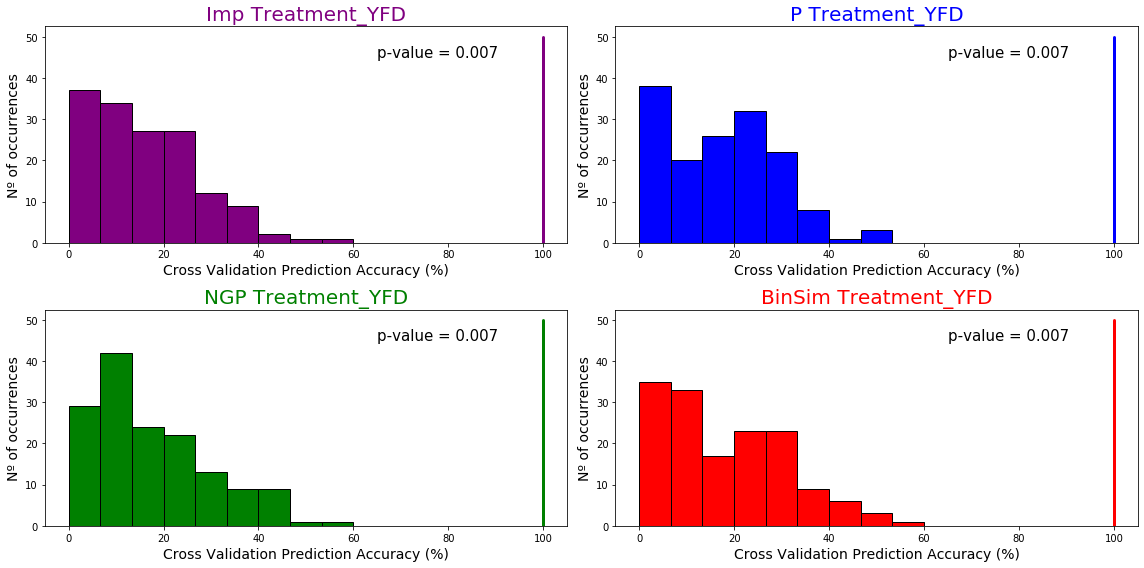

In [118]:
print('Permutation Test - Yeast Formula Dataset (MSNorm) - PLS-DA')
# Plot the Permutations test results - Histogram of predictive accuracies of permutated labels and comparison to reference
# predictive accuracy.
f, axes = plt.subplots(2, 2, figsize = (16,8))

Names = ['Imp Treatment_YFD','P Treatment_YFD','NGP Treatment_YFD','BinSim Treatment_YFD']
colors = ['purple', 'blue', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_YD.cdl.labels)

# Setting the parameters of the figure
for q, name, color in zip(quadrant, Names, colors):
    q.hist(np.array(PMs_PLS[name])*100, n_labels, range=(0, 100.001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]*100], ylim, '-', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name], solid_capstyle='round')
    #q.set(xlabel='Cross Validation Prediction Accuracy (%)', ylabel='Nº of occurrences')
    q.set_xlabel('Cross Validation Prediction Accuracy (%)', fontsize=14)
    q.set_ylabel('Nº of occurrences', fontsize=14)
    q.text(65,45, 'p-value = %.3f' % pvalue_PLS[name], fontsize = 15)
    q.set_title(name, size = 20, color = color)

plt.tight_layout()

In [119]:
def Feat_Selection_sim(VIP_s, Weight_s, RegCoef_s, percent = 0.02):
    """See the similarity of features chosen (% of intersection between them) with different methods."""
    number = round(percent*len(VIP_s))
    VIP = []
    Weights = []
    RegCoef = []
    for i in range(number):
        VIP.append(VIP_s[:number][i][0])
        Weights.append(Weight_s[:number][i][0])
        RegCoef.append(RegCoef_s[:number][i][0])
    Features = (VIP, Weights, RegCoef)
    Table = pd.DataFrame(np.empty((3,3)), columns = ['VIP', 'Weights', 'RegCoef'], index = ['VIP', 'Weights', 'RegCoef'])
    for i in range(len(Features)):
        for j in range(len(Features)):
            #list comprehension other way
            Table.iloc[i,j] = len(set(Features[i]).intersection(Features[j]))/number
    return Table